# Importing required modules

In [3]:
# Modules required for data handling and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_style("whitegrid")

# Modules required for accessing the file system.
import os
import json

# Modules used for model training and transfer learning
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.applications as cnns
from tensorflow.keras import Model

# Modules used for model evaluation and selection.
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.metrics import roc_curve, precision_recall_curve

# Modules used for ensembling
import collections

# Disabling logging
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Constants
TRAIN_CSV_DIR = "/kaggle/input/retinal-disease-classification/Training_Set/Training_Set/RFMiD_Training_Labels.csv"
TEST_CSV_DIR = "/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/RFMiD_Testing_Labels.csv"
VAL_CSV_DIR = "/kaggle/input/retinal-disease-classification/Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv"

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import tensorflow as tf
tf.test.is_gpu_available()

True

# Selection of Classes for Multilabel Classification

In [4]:
train_labels = pd.read_csv(TRAIN_CSV_DIR)
test_labels = pd.read_csv(TEST_CSV_DIR)
val_labels = pd.read_csv(VAL_CSV_DIR)

In [5]:
train_labels.head()

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
infected_retinas = dict(train_labels.drop(["ID", "Disease_Risk"], axis=1).sum().sort_values(ascending=False).head(2))

In [7]:
infected_retinas

{'DR': 376, 'MH': 317}

In [8]:
train_labels = train_labels[["ID"]+list(infected_retinas.keys())]
test_labels = test_labels[["ID"]+list(infected_retinas.keys())]
val_labels = val_labels[["ID"]+list(infected_retinas.keys())]

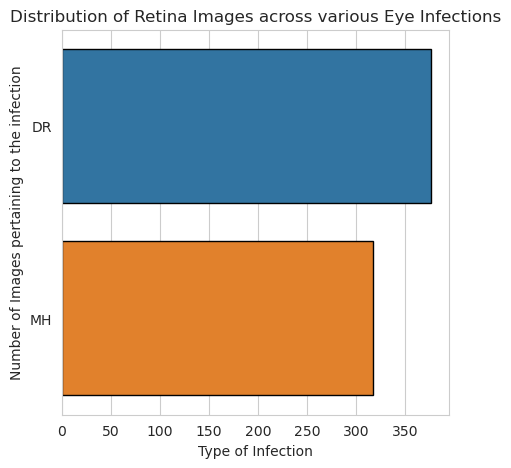

In [9]:
infected_retinas = dict(train_labels.drop(["ID"], axis=1).sum())
retina_infections = list(infected_retinas.keys())
infection_freq = list(infected_retinas.values())
plt.figure(figsize = (5,5))
sns.barplot(y = retina_infections,
            x = infection_freq,
            edgecolor = "black",
            orient = "h")
plt.title("Distribution of Retina Images across various Eye Infections")
plt.xlabel("Type of Infection")
plt.ylabel("Number of Images pertaining to the infection")
plt.show()

# Training a Multilabel Classifier

## Converting the IDs to Paths

In [10]:
TRAIN_IMG_DIR="/kaggle/input/retinal-disease-classification/Training_Set/Training_Set/Training"
TEST_IMG_DIR = "/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/Test"
VAL_IMG_DIR = "/kaggle/input/retinal-disease-classification/Evaluation_Set/Evaluation_Set/Validation"
def id_to_path(id : int, IMG_DIR : str):
    return os.path.join(IMG_DIR, str(id) + ".png")

In [11]:
train_labels["IMG_DIR"] = TRAIN_IMG_DIR
train_labels["IMG_DIR"] = train_labels.apply(lambda x: id_to_path(x.ID, x.IMG_DIR), 
                                             axis=1)
test_labels["IMG_DIR"] = TEST_IMG_DIR
test_labels["IMG_DIR"] = test_labels.apply(lambda x: id_to_path(x.ID, x.IMG_DIR), 
                                           axis=1)
val_labels["IMG_DIR"] = VAL_IMG_DIR
val_labels["IMG_DIR"] = val_labels.apply(lambda x: id_to_path(x.ID, x.IMG_DIR), 
                                         axis=1)

## Image Preprocessing

In [12]:
class ImagePreprocessor:
    def __init__(self, cnn_variant, input_size, labels):
        self.cnn_variant = cnn_variant
        self.train_gen = None
        self.test_gen = None
        self.val_gen = None
        self.input_size = input_size
        self.labels = labels
        
    def create_generators(self):
        self.train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=self.cnn_variant.preprocess_input
        )

        self.test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=self.cnn_variant.preprocess_input
        )

        self.val_gen =  tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=self.cnn_variant.preprocess_input
        )
        
    def preprocess(self):
        train_images = self.train_gen.flow_from_dataframe(
              train_labels,
              x_col="IMG_DIR", 
              y_col=self.labels,
              target_size=self.input_size,
              color_mode='rgb',
              batch_size=32,
              class_mode="binary",
              shuffle=True
        )

        val_images = self.val_gen.flow_from_dataframe(
              test_labels,
              x_col="IMG_DIR", 
              y_col=self.labels,
              target_size=self.input_size,
              color_mode='rgb',
              batch_size=32,
              class_mode="binary",
              shuffle=True
        )

        test_images = self.test_gen.flow_from_dataframe(
              val_labels,
              x_col="IMG_DIR", 
              y_col=self.labels,
              color_mode='rgb',
              target_size=self.input_size,
              batch_size=32,
              class_mode="binary",
              shuffle=False
        )

        return train_images, val_images, test_images

## Domain Adaptation

In [13]:
class TransferLearning:

    def __init__(self, train, val, model, classes : int) -> None:
        self.train = train
        self.val = val
        self.model = model
        self.history = None
        self.fine_tune_from = 100
        self.INPUT_SIZE = (200,200,3)
        self.classes = classes
    
    def mark_layers_non_trainable(self):
        for layer in self.model.layers:
            layer.trainable = False
    
    def add_final_layer(self):
        self.x = Flatten()(self.model.output)
        self.x = Dense(1000, activation='relu')(self.x)
        self.predictions = Dense(self.classes, activation = 'sigmoid')(self.x)

    def compile_model(self):
        self.model = Model(inputs = self.model.input, 
                           outputs = self.predictions)
        self.model.compile(optimizer='adam', 
                           loss="binary_crossentropy", 
                           metrics=['accuracy',
                                    tf.keras.metrics.AUC(name="auc",from_logits=True),
                                    tf.keras.metrics.FalseNegatives(name="false_negatives"),
                                    tf.keras.metrics.FalsePositives(name="false_positives"),
                                    tf.keras.metrics.Precision(name="precision"),
                                    tf.keras.metrics.Recall(name="recall")])
    
    def train_model(self):
        self.history = self.model.fit(self.train,
                                      batch_size=32, 
                                      epochs=15, 
                                      validation_data=self.val,
                                      callbacks=[
                                        tf.keras.callbacks.EarlyStopping(
                                            monitor='val_loss',
                                            patience=5,
                                            restore_best_weights=True
                                        )
                                     ])

## Experimentation of different CNN architectures

In [14]:
def experiment_model(preprocessing_function, model, input_size : tuple, target_label : str):
    preprocessor = ImagePreprocessor(preprocessing_function, 
                                     input_size, 
                                     target_label)
    preprocessor.create_generators()
    train, val, test = preprocessor.preprocess()
    modelbuilder = TransferLearning(train, 
                                    val, 
                                    model, 
                                    1)
    modelbuilder.mark_layers_non_trainable()
    modelbuilder.add_final_layer()
    modelbuilder.compile_model()
    modelbuilder.train_model()
    return modelbuilder.model, modelbuilder.history, test

## Model Evaluation

In [15]:
class ModelEvaluator:
    def __init__(self, history, classes : list, model, test, threshold : float):
        self.history = history
        self.model = model
        self.test = test
        self.classes = classes
        self.num_classes = len(self.classes)
        self.predictions = None
        self.t = threshold
    
    def __plot_metric(self, ax, metric: str,train_metric : str, val_metric : str):
        
        ax.plot(self.history.history[train_metric])
        ax.plot(self.history.history[val_metric])
        ax.title.set_text(train_metric + " v/s " + val_metric)
        ax.set_xlabel('Epochs')
        ax.set_ylabel(metric.title())
        ax.legend(['Train','Val'])
    
    def training_history(self):
        rows = 4
        columns = 2
        c = 0
        metrics = ["loss", "accuracy", "auc", "false_negatives", "false_positives", "precision", "recall"]
        fig, axs = plt.subplots(rows, columns,figsize=(15,15))
        for metric in metrics:
            self.__plot_metric(axs[c//columns, c%columns], 
                               metric.replace("_", " ").title(), 
                               metric, "val_"+metric)
            c += 1
        fig.suptitle("Training History of the Model")
        plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.5)
        plt.show()
    
    def __clip_sigmoid_output(self, p : float):
        if p >= self.t:
            return 1
        else:
            return 0
    
    def predict(self):
        self.predictions = self.model.predict(self.test).flatten()
        self.predictions = list(map(self.__clip_sigmoid_output, self.predictions))
    
    def class_report(self):
        sns.heatmap(tf.math.confusion_matrix(self.test.labels, self.predictions, num_classes=2), 
                    annot=True, cmap="crest")
        print(classification_report(self.test.labels, self.predictions, target_names=self.classes))

In [16]:
train_labels["DR"] = train_labels["DR"].astype(str)
test_labels["DR"] = test_labels["DR"].astype(str)
val_labels["DR"] = val_labels["DR"].astype(str)

## Threshold Tuning

In [17]:
class ThresholdTuner:
    def __init__(self, model, test):
        self.model = model
        self.test = test
        self.predictions_raw = None
        self.f1_scores = []
        self.threshold = None
    
    def __predict_test(self):
        self.predictions_raw = self.model.predict(self.test).flatten()
    
    def __clip_logits(self, t : float, p : float):
        if p >= t:
            return 1
        else:
            return 0
    
    def __plot_raw_logits(self, ax):
        ax.hist(self.predictions_raw, edgecolor="black")
        ax.title.set_text("Distribution of logits at final layer")
        ax.set_xlabel("Logits")
        ax.set_ylabel("Frequency")
    
    def __tune_threshold_pr_curve(self, ax):
        precision, recall, thresholds = precision_recall_curve(self.test.labels, self.predictions_raw)
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.argmax(fscore)
        print('Best Threshold=%f, F-score=%.3f using PR Curve' % (thresholds[ix], fscore[ix]))
        self.threshold = thresholds[ix]
        no_skill = np.count_nonzero(self.test.labels == 1) / len(self.test.labels)
        ax.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill') 
        ax.plot(recall, precision, marker='.', label='Logistic') 
        ax.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best') 
        ax.title.set_text("PR Curve")
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend()
        
    def find_optimal_thresholds(self):
        self.__predict_test()
        rows = 1
        columns = 2
        fig, axs = plt.subplots(rows, columns,figsize=(8,5))
        self.__plot_raw_logits(axs[0])
        self.__tune_threshold_pr_curve(axs[1])
        fig.suptitle("Threshold Moving for Binary Classifier")
        plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.5)
        plt.show()

In [18]:
dr = dict()
mh = dict()

# Diabetic Retinopathy

## EfficientNetB0

In [57]:
efficientnet, history, efficientnet_test = experiment_model(cnns.efficientnet, 
                                                            cnns.EfficientNetB0(include_top=False, 
                                                                                input_shape=(200,200,3)),
                                                            (200,200), "DR")

Found 1920 validated image filenames belonging to 2 classes.

Found 640 validated image filenames belonging to 2 classes.

Found 640 validated image filenames belonging to 2 classes.

Epoch 1/15

60/60 [==============================] - 319s 5s/step - loss: 5.3599 - accuracy: 0.8151 - auc: 0.7290 - false_negatives: 174.0000 - false_positives: 181.0000 - precision: 0.5274 - recall: 0.5372 - val_loss: 2.1766 - val_accuracy: 0.8656 - val_auc: 0.7942 - val_false_negatives: 51.0000 - val_false_positives: 35.0000 - val_precision: 0.6759 - val_recall: 0.5887

Epoch 2/15

60/60 [==============================] - 317s 5s/step - loss: 1.2096 - accuracy: 0.8927 - auc: 0.8593 - false_negatives: 104.0000 - false_positives: 102.0000 - precision: 0.7273 - recall: 0.7234 - val_loss: 3.4949 - val_accuracy: 0.6953 - val_auc: 0.8468 - val_false_negatives: 1.0000 - val_false_positives: 194.0000 - val_precision: 0.3880 - val_recall: 0.9919

Epoch 3/15

60/60 [==============================] - 300s 5s/step 

### Threshold Tuning

In [58]:
tuner = ThresholdTuner(efficientnet, efficientnet_test)

20/20 [==============================] - 90s 5s/step

Best Threshold=0.722048, F-score=0.749 using PR Curve


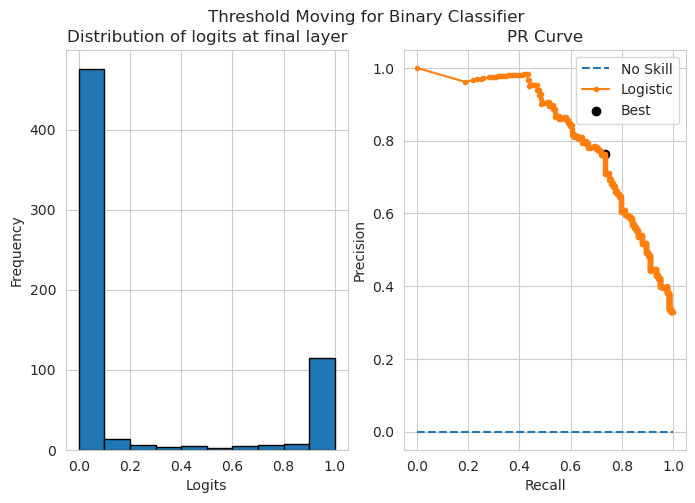

In [59]:
tuner.find_optimal_thresholds()

### Model Evaluation

In [60]:
me = ModelEvaluator(history, ["Not Infected", "Infected"], efficientnet, efficientnet_test, tuner.threshold)

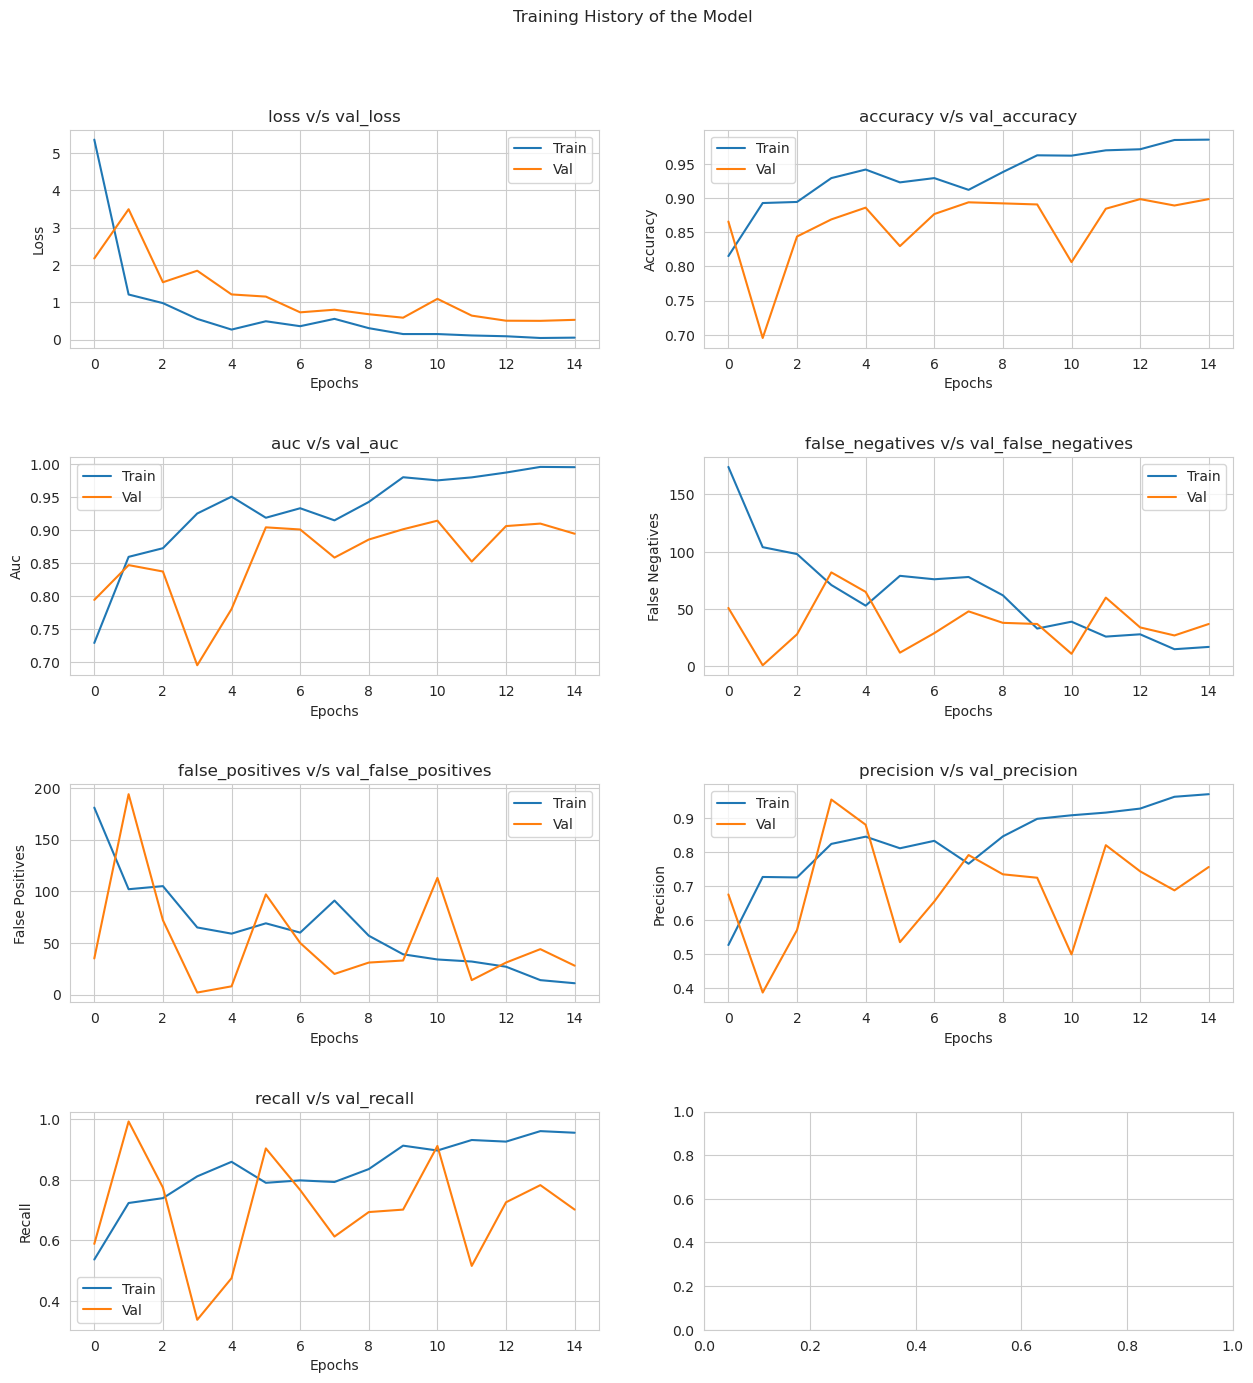

20/20 [==============================] - 71s 4s/step


In [61]:
me.training_history()
me.predict()

              precision    recall  f1-score   support



Not Infected       0.93      0.94      0.94       508

    Infected       0.76      0.73      0.75       132



    accuracy                           0.90       640

   macro avg       0.85      0.84      0.84       640

weighted avg       0.90      0.90      0.90       640




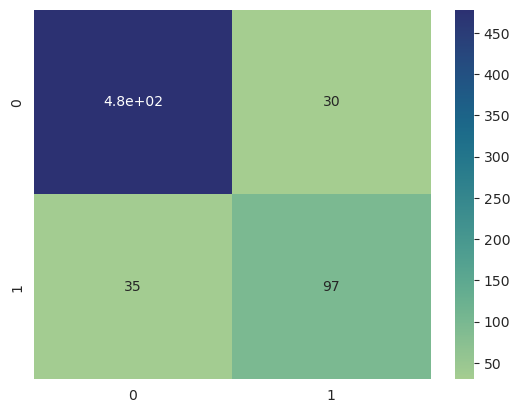

In [62]:
me.class_report()

### Saving the essential data

In [63]:
dr["EfficientNetB0"] = {"Predictions": tuner.predictions_raw.tolist(),
                        "Threshold": float(tuner.threshold), 
                        "Ground Truth": tuner.test.labels,
                        "History": history.history
                       }

In [64]:
# with open("/kaggle/working/DR.json", 'w') as fp:
#     json.dump(dr, fp)

## ResNet152

In [65]:
model, history, test = experiment_model(cnns.resnet, 
                                        cnns.ResNet152(include_top=False, 
                                                            input_shape=(200,200,3)),
                                        (200,200), "DR")


234698864/234698864 [==============================] - 8s 0us/step

Found 1920 validated image filenames belonging to 2 classes.

Found 640 validated image filenames belonging to 2 classes.

Found 640 validated image filenames belonging to 2 classes.

Epoch 1/15

60/60 [==============================] - 357s 6s/step - loss: 12.8264 - accuracy: 0.8010 - auc: 0.7182 - false_negatives: 181.0000 - false_positives: 201.0000 - precision: 0.4924 - recall: 0.5186 - val_loss: 5.4380 - val_accuracy: 0.8469 - val_auc: 0.6232 - val_false_negatives: 97.0000 - val_false_positives: 1.0000 - val_precision: 0.9643 - val_recall: 0.2177

Epoch 2/15

60/60 [==============================] - 302s 5s/step - loss: 1.8540 - accuracy: 0.8870 - auc: 0.8436 - false_negatives: 114.0000 - false_positives: 103.0000 - precision: 0.7178 - recall: 0.6968 - val_loss: 2.0978 - val_accuracy: 0.8891 - val_auc: 0.7632 - val_false_negatives: 61.0000 - val_false_positives: 10.0000 - val_precision: 0.8630 - val_recall: 0.508

### Threshold Tuning

In [66]:
tuner = ThresholdTuner(model, test)

20/20 [==============================] - 88s 4s/step

Best Threshold=0.981385, F-score=0.706 using PR Curve


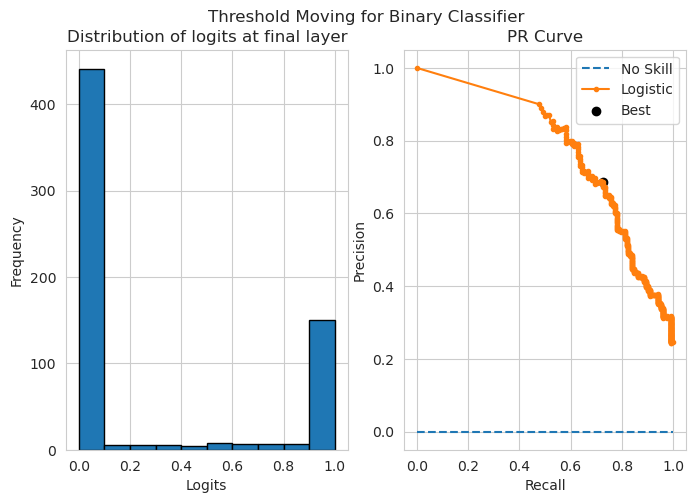

In [67]:
tuner.find_optimal_thresholds()

### Model Evaluation

In [68]:
me = ModelEvaluator(history, ["Not Infected", "Infected"], model, test, tuner.threshold)

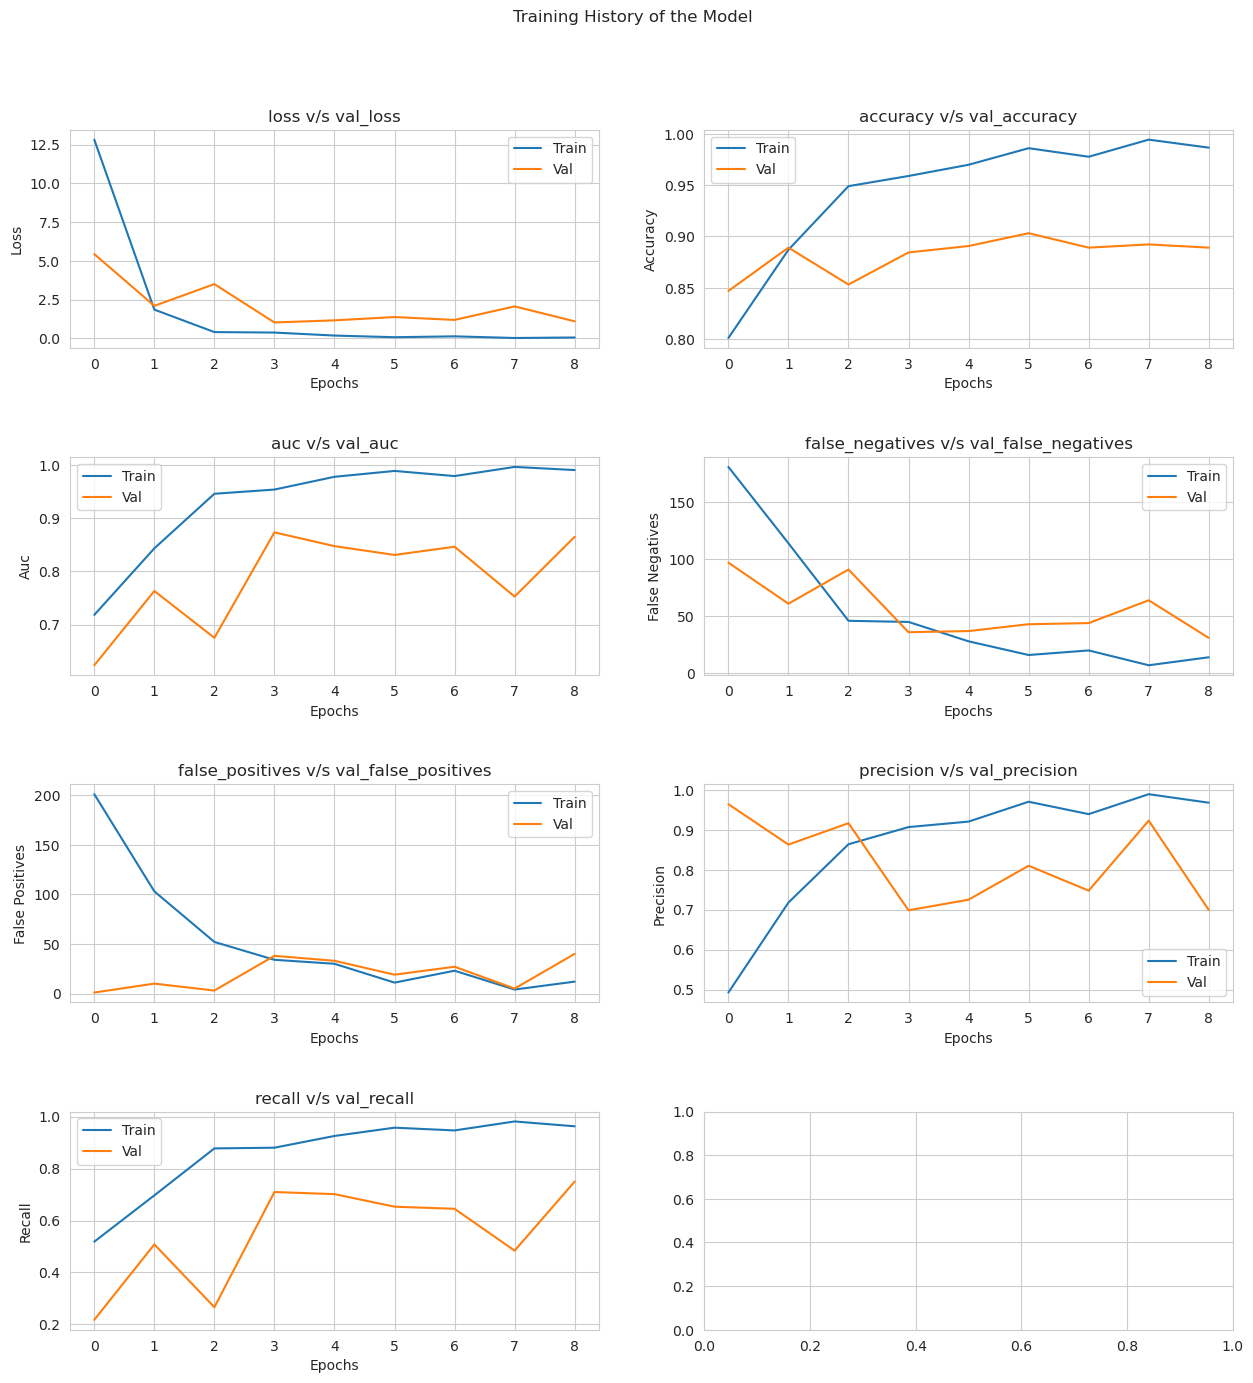

20/20 [==============================] - 72s 4s/step


In [69]:
me.training_history()
me.predict()

              precision    recall  f1-score   support



Not Infected       0.93      0.91      0.92       508

    Infected       0.69      0.73      0.71       132



    accuracy                           0.88       640

   macro avg       0.81      0.82      0.81       640

weighted avg       0.88      0.88      0.88       640




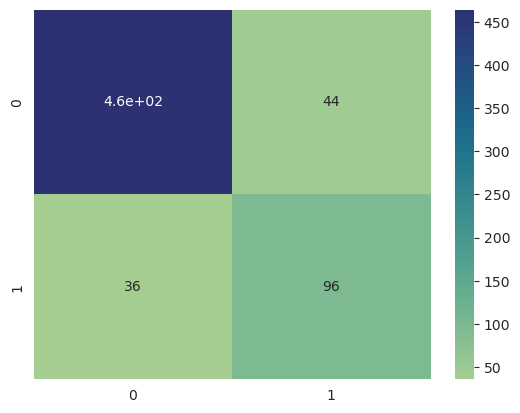

In [70]:
me.class_report()

### Saving essential data

In [71]:
dr["ResNet152"] = {"Predictions": tuner.predictions_raw.tolist(),
                   "Threshold": float(tuner.threshold),
                   "Ground Truth" : tuner.test.labels,
                   "History" : history.history
                   }

In [72]:
# with open("/kaggle/working/DR.json", 'w') as fp:
#     json.dump(dr, fp)

## VGG16

In [19]:
model, history, test = experiment_model(cnns.vgg16, 
                                        cnns.VGG16(include_top=False, 
                                                   input_shape=(200,200,3)),
                                        (200,200), "DR")


58889256/58889256 [==============================] - 3s 0us/step

Found 1920 validated image filenames belonging to 2 classes.

Found 640 validated image filenames belonging to 2 classes.

Found 640 validated image filenames belonging to 2 classes.

Epoch 1/15

60/60 [==============================] - 389s 6s/step - loss: 6.0187 - accuracy: 0.8198 - auc: 0.7404 - false_negatives: 172.0000 - false_positives: 174.0000 - precision: 0.5397 - recall: 0.5426 - val_loss: 1.4777 - val_accuracy: 0.8797 - val_auc: 0.8771 - val_false_negatives: 27.0000 - val_false_positives: 50.0000 - val_precision: 0.6599 - val_recall: 0.7823

Epoch 2/15

60/60 [==============================] - 313s 5s/step - loss: 1.1865 - accuracy: 0.8891 - auc: 0.8616 - false_negatives: 102.0000 - false_positives: 111.0000 - precision: 0.7117 - recall: 0.7287 - val_loss: 1.1513 - val_accuracy: 0.8969 - val_auc: 0.8516 - val_false_negatives: 35.0000 - val_false_positives: 31.0000 - val_precision: 0.7417 - val_recall: 0.7177


### Threshold Tuning

In [20]:
tuner = ThresholdTuner(model, test)

20/20 [==============================] - 91s 5s/step

Best Threshold=0.993780, F-score=0.698 using PR Curve


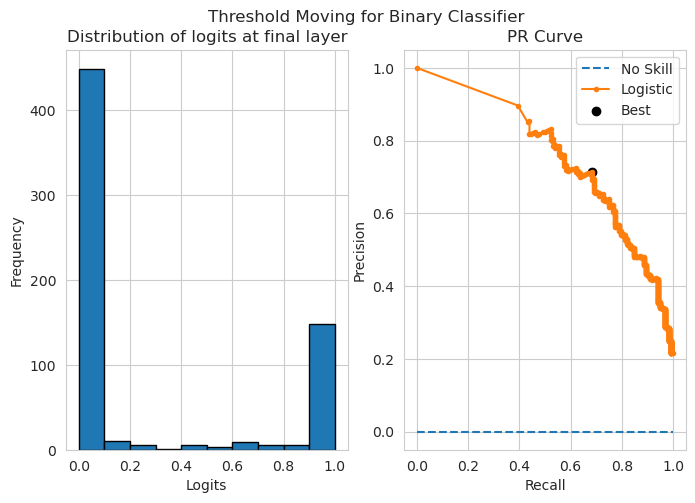

In [21]:
tuner.find_optimal_thresholds()

### Model Evaluation

In [22]:
me = ModelEvaluator(history, ["Not Infected", "Infected"], model, test, tuner.threshold)

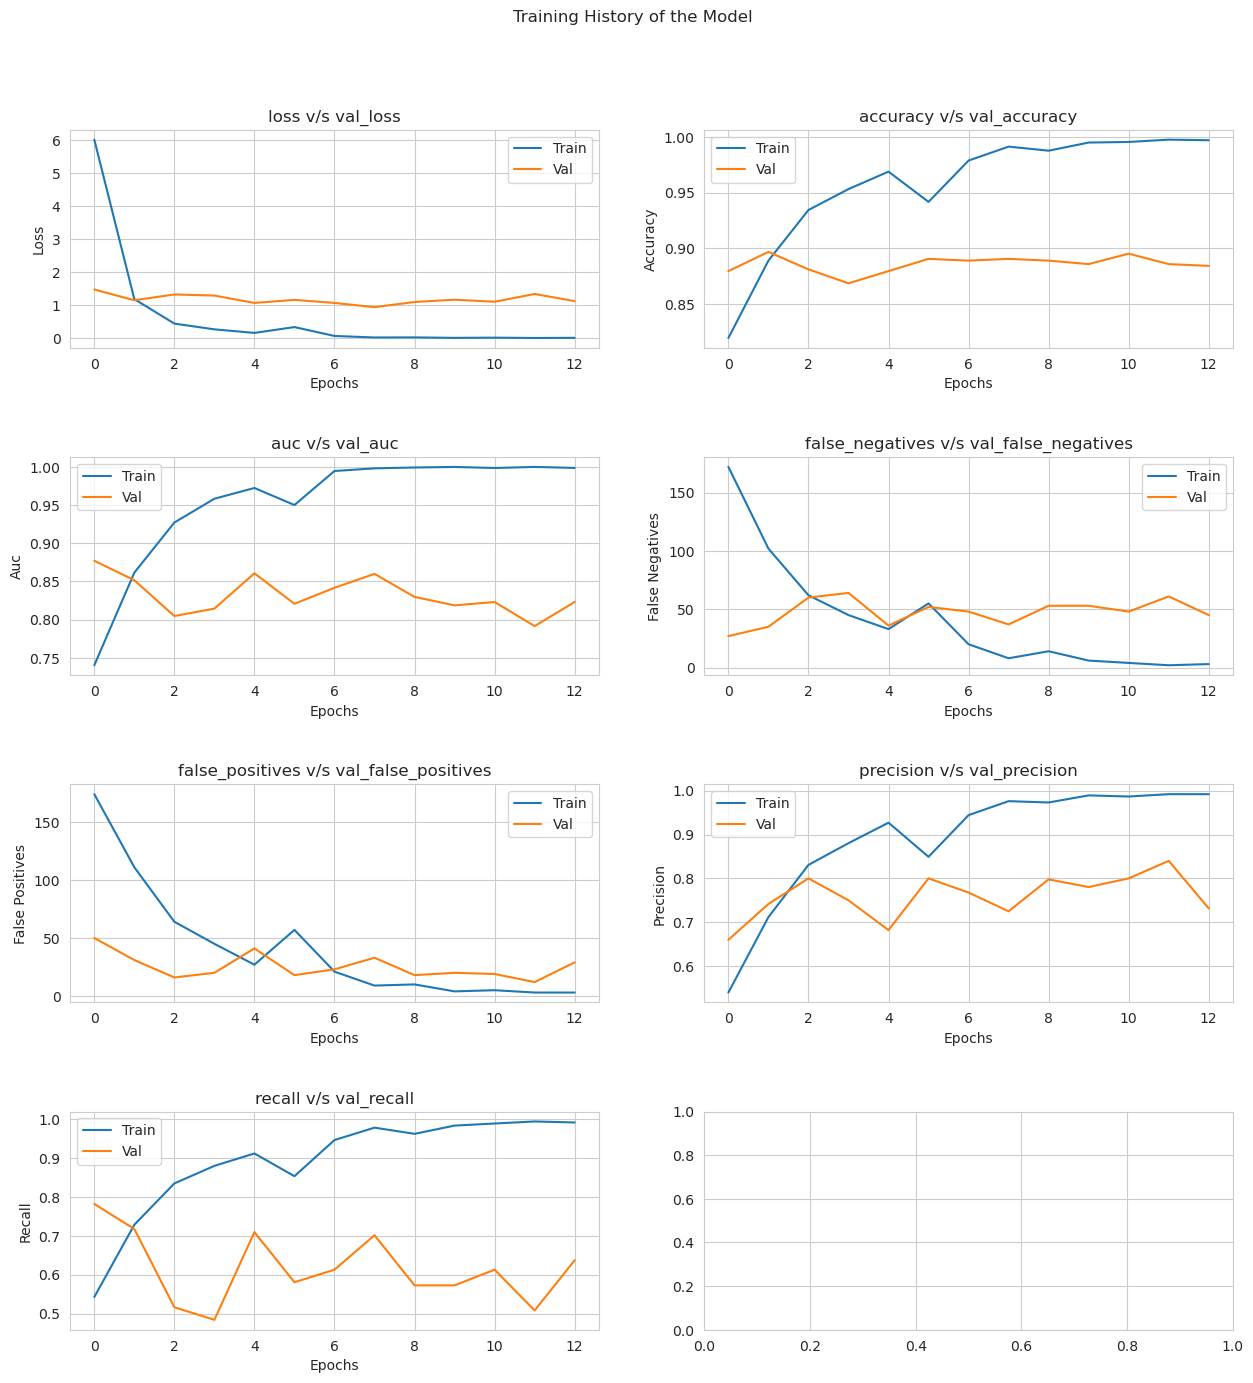

20/20 [==============================] - 71s 4s/step


In [23]:
me.training_history()
me.predict()

              precision    recall  f1-score   support



Not Infected       0.92      0.93      0.92       508

    Infected       0.71      0.68      0.70       132



    accuracy                           0.88       640

   macro avg       0.82      0.81      0.81       640

weighted avg       0.88      0.88      0.88       640




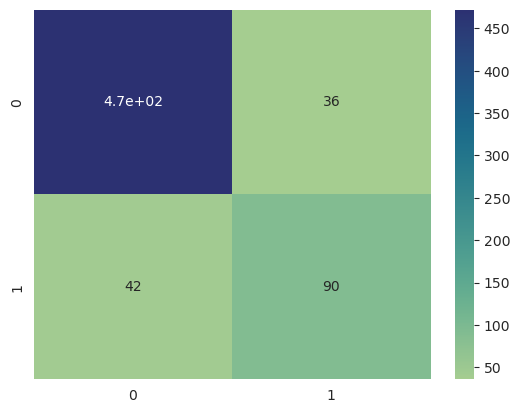

In [24]:
me.class_report()

### Saving essential data

In [25]:
dr["VGG16"] = {"Predictions": tuner.predictions_raw.tolist(),
               "Threshold": float(tuner.threshold),
               "Ground Truth" : tuner.test.labels,
               "History" : history.history
               }

In [26]:
# with open("/kaggle/working/DR.json", 'w') as fp:
#     json.dump(dr, fp)

## DenseNet169

In [27]:
model, history, test = experiment_model(cnns.densenet, 
                                        cnns.DenseNet169(include_top=False, 
                                                         input_shape=(200,200,3)),
                                        (200,200), "DR")


51877672/51877672 [==============================] - 3s 0us/step

Found 1920 validated image filenames belonging to 2 classes.

Found 640 validated image filenames belonging to 2 classes.

Found 640 validated image filenames belonging to 2 classes.

Epoch 1/15

60/60 [==============================] - 373s 6s/step - loss: 5.4635 - accuracy: 0.8062 - auc: 0.7114 - false_negatives: 184.0000 - false_positives: 188.0000 - precision: 0.5053 - recall: 0.5106 - val_loss: 0.9048 - val_accuracy: 0.8906 - val_auc: 0.8183 - val_false_negatives: 50.0000 - val_false_positives: 20.0000 - val_precision: 0.7872 - val_recall: 0.5968

Epoch 2/15

60/60 [==============================] - 311s 5s/step - loss: 0.6114 - accuracy: 0.8901 - auc: 0.8817 - false_negatives: 110.0000 - false_positives: 101.0000 - precision: 0.7248 - recall: 0.7074 - val_loss: 0.7000 - val_accuracy: 0.8781 - val_auc: 0.8457 - val_false_negatives: 47.0000 - val_false_positives: 31.0000 - val_precision: 0.7130 - val_recall: 0.6210


### Threshold Tuning

In [28]:
tuner = ThresholdTuner(model, test)

20/20 [==============================] - 81s 4s/step

Best Threshold=0.893461, F-score=0.763 using PR Curve


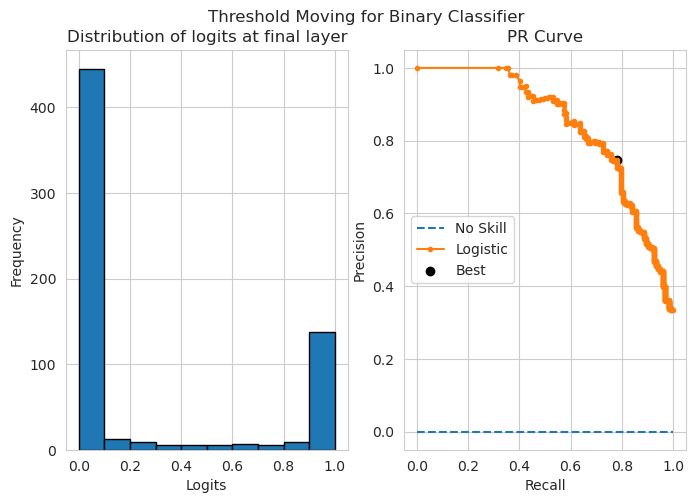

In [29]:
tuner.find_optimal_thresholds()

### Model Evaluation

In [30]:
me = ModelEvaluator(history, ["Not Infected", "Infected"], model, test, tuner.threshold)

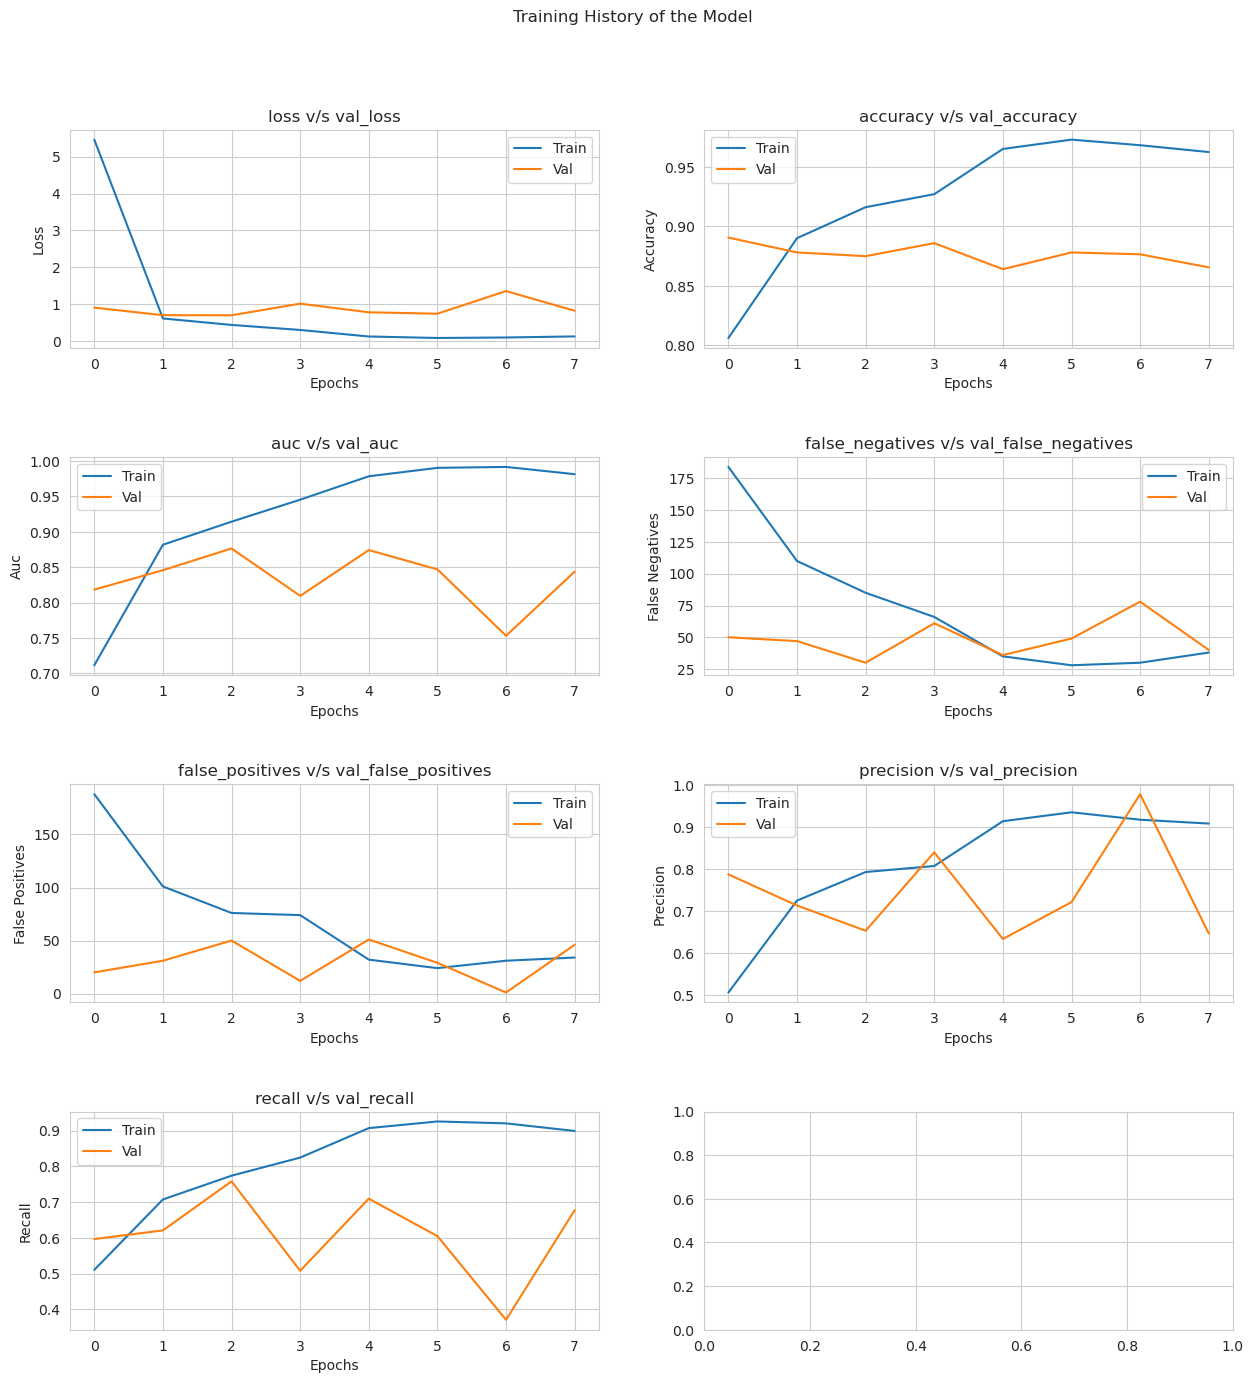

20/20 [==============================] - 75s 4s/step


In [31]:
me.training_history()
me.predict()

              precision    recall  f1-score   support



Not Infected       0.94      0.93      0.94       508

    Infected       0.75      0.78      0.76       132



    accuracy                           0.90       640

   macro avg       0.84      0.86      0.85       640

weighted avg       0.90      0.90      0.90       640




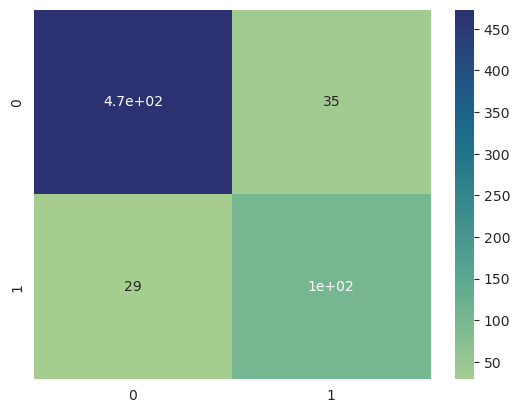

In [32]:
me.class_report()

### Saving essential data

In [33]:
dr["DenseNet169"] = {"Predictions": tuner.predictions_raw.tolist(),
                     "Threshold": float(tuner.threshold),
                     "Ground Truth" : tuner.test.labels,
                     "History" : history.history
                     }

## Serialization of all information to JSON

In [34]:
with open("/kaggle/working/DR.json", 'w') as fp:
    json.dump(dr, fp)

# Macular Hole

## EfficientNetB0

In [ ]:
efficientnet, history, efficientnet_test = experiment_model(cnns.efficientnet, 
                                                            cnns.EfficientNetB0(include_top=False, 
                                                                                input_shape=(200,200,3)),
                                                            (200,200), "MH")


16705208/16705208 [==============================] - 0s 0us/step

Found 1920 validated image filenames belonging to 2 classes.

Found 640 validated image filenames belonging to 2 classes.

Found 640 validated image filenames belonging to 2 classes.

Epoch 1/25

60/60 [==============================] - 371s 6s/step - loss: 4.5393 - accuracy: 0.8573 - auc: 0.7681 - false_negatives: 140.0000 - false_positives: 134.0000 - precision: 0.5691 - recall: 0.5584 - val_loss: 0.5427 - val_accuracy: 0.8984 - val_auc: 0.9219 - val_false_negatives: 17.0000 - val_false_positives: 48.0000 - val_precision: 0.6444 - val_recall: 0.8365

Epoch 2/25

60/60 [==============================] - 294s 5s/step - loss: 0.6214 - accuracy: 0.9083 - auc: 0.8787 - false_negatives: 85.0000 - false_positives: 91.0000 - precision: 0.7183 - recall: 0.7319 - val_loss: 1.8286 - val_accuracy: 0.7641 - val_auc: 0.8868 - val_false_negatives: 6.0000 - val_false_positives: 145.0000 - val_precision: 0.4033 - val_recall: 0.9423

E

### Threshold Tuning

In [ ]:
tuner = ThresholdTuner(efficientnet, efficientnet_test)

20/20 [==============================] - 86s 4s/step

Best Threshold=0.006269, F-score=0.750 using PR Curve


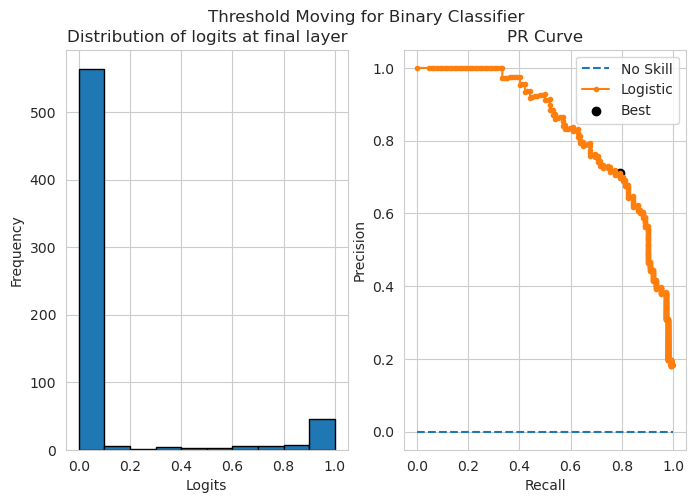

In [ ]:
tuner.find_optimal_thresholds()

### Model Evaluation

In [ ]:
me = ModelEvaluator(history, ["Not Infected", "Infected"], efficientnet, efficientnet_test, tuner.threshold)

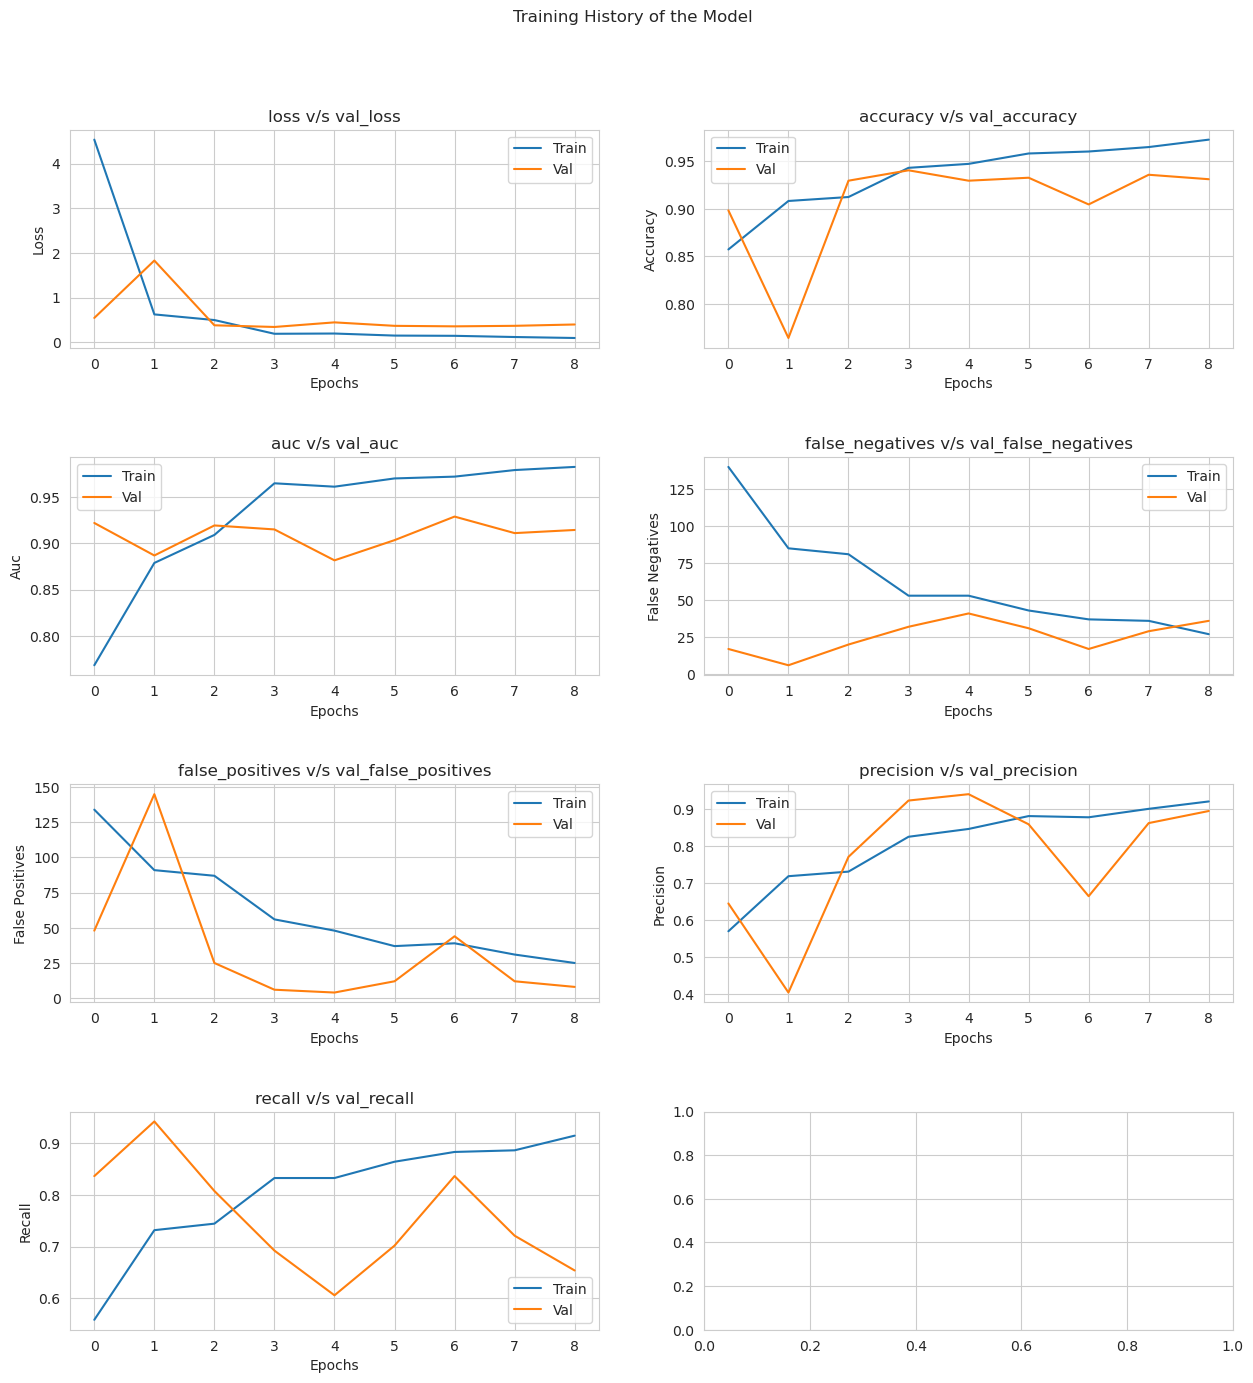

20/20 [==============================] - 70s 4s/step


In [ ]:
me.training_history()
me.predict()

              precision    recall  f1-score   support



Not Infected       0.96      0.94      0.95       538

    Infected       0.71      0.79      0.75       102



    accuracy                           0.92       640

   macro avg       0.84      0.87      0.85       640

weighted avg       0.92      0.92      0.92       640




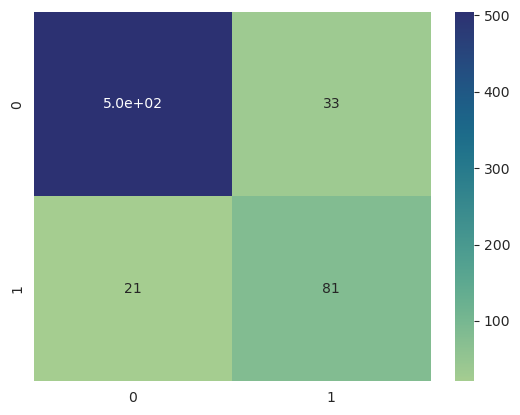

In [ ]:
me.class_report()

### Saving the essential data

In [ ]:
mh["EfficientNetB0"] = {"Predictions": tuner.predictions_raw.tolist(),
                        "Threshold": float(tuner.threshold), 
                        "Ground Truth": tuner.test.labels,
                        "History": history.history
                       }

## ResNet152

In [ ]:
model, history, test = experiment_model(cnns.resnet, 
                                        cnns.ResNet152(include_top=False, 
                                                            input_shape=(200,200,3)),
                                        (200,200), "MH")


234698864/234698864 [==============================] - 2s 0us/step

Found 1920 validated image filenames belonging to 2 classes.

Found 640 validated image filenames belonging to 2 classes.

Found 640 validated image filenames belonging to 2 classes.

Epoch 1/25

60/60 [==============================] - 343s 6s/step - loss: 10.2086 - accuracy: 0.8625 - auc: 0.7811 - false_negatives: 126.0000 - false_positives: 138.0000 - precision: 0.5805 - recall: 0.6025 - val_loss: 1.1919 - val_accuracy: 0.8875 - val_auc: 0.8910 - val_false_negatives: 20.0000 - val_false_positives: 52.0000 - val_precision: 0.6176 - val_recall: 0.8077

Epoch 2/25

60/60 [==============================] - 318s 5s/step - loss: 0.7689 - accuracy: 0.9187 - auc: 0.8908 - false_negatives: 78.0000 - false_positives: 78.0000 - precision: 0.7539 - recall: 0.7539 - val_loss: 0.9442 - val_accuracy: 0.8859 - val_auc: 0.9152 - val_false_negatives: 15.0000 - val_false_positives: 58.0000 - val_precision: 0.6054 - val_recall: 0.8558

### Threshold Tuning

In [ ]:
tuner = ThresholdTuner(model, test)

20/20 [==============================] - 91s 4s/step

Best Threshold=0.017162, F-score=0.758 using PR Curve


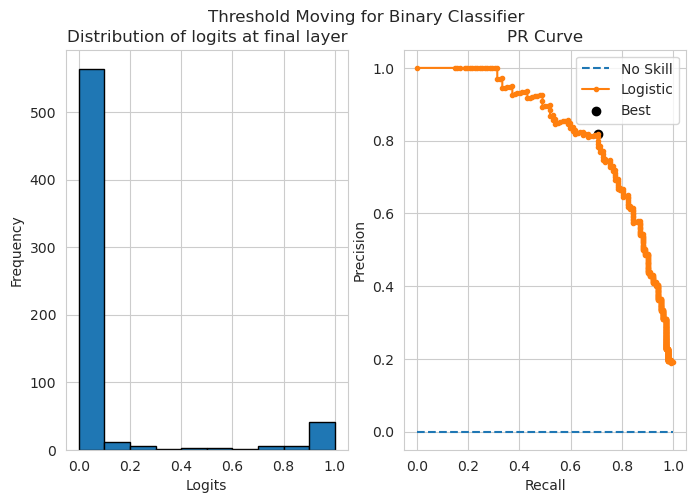

In [ ]:
tuner.find_optimal_thresholds()

### Model Evaluation

In [ ]:
me = ModelEvaluator(history, ["Not Infected", "Infected"], model, test, tuner.threshold)

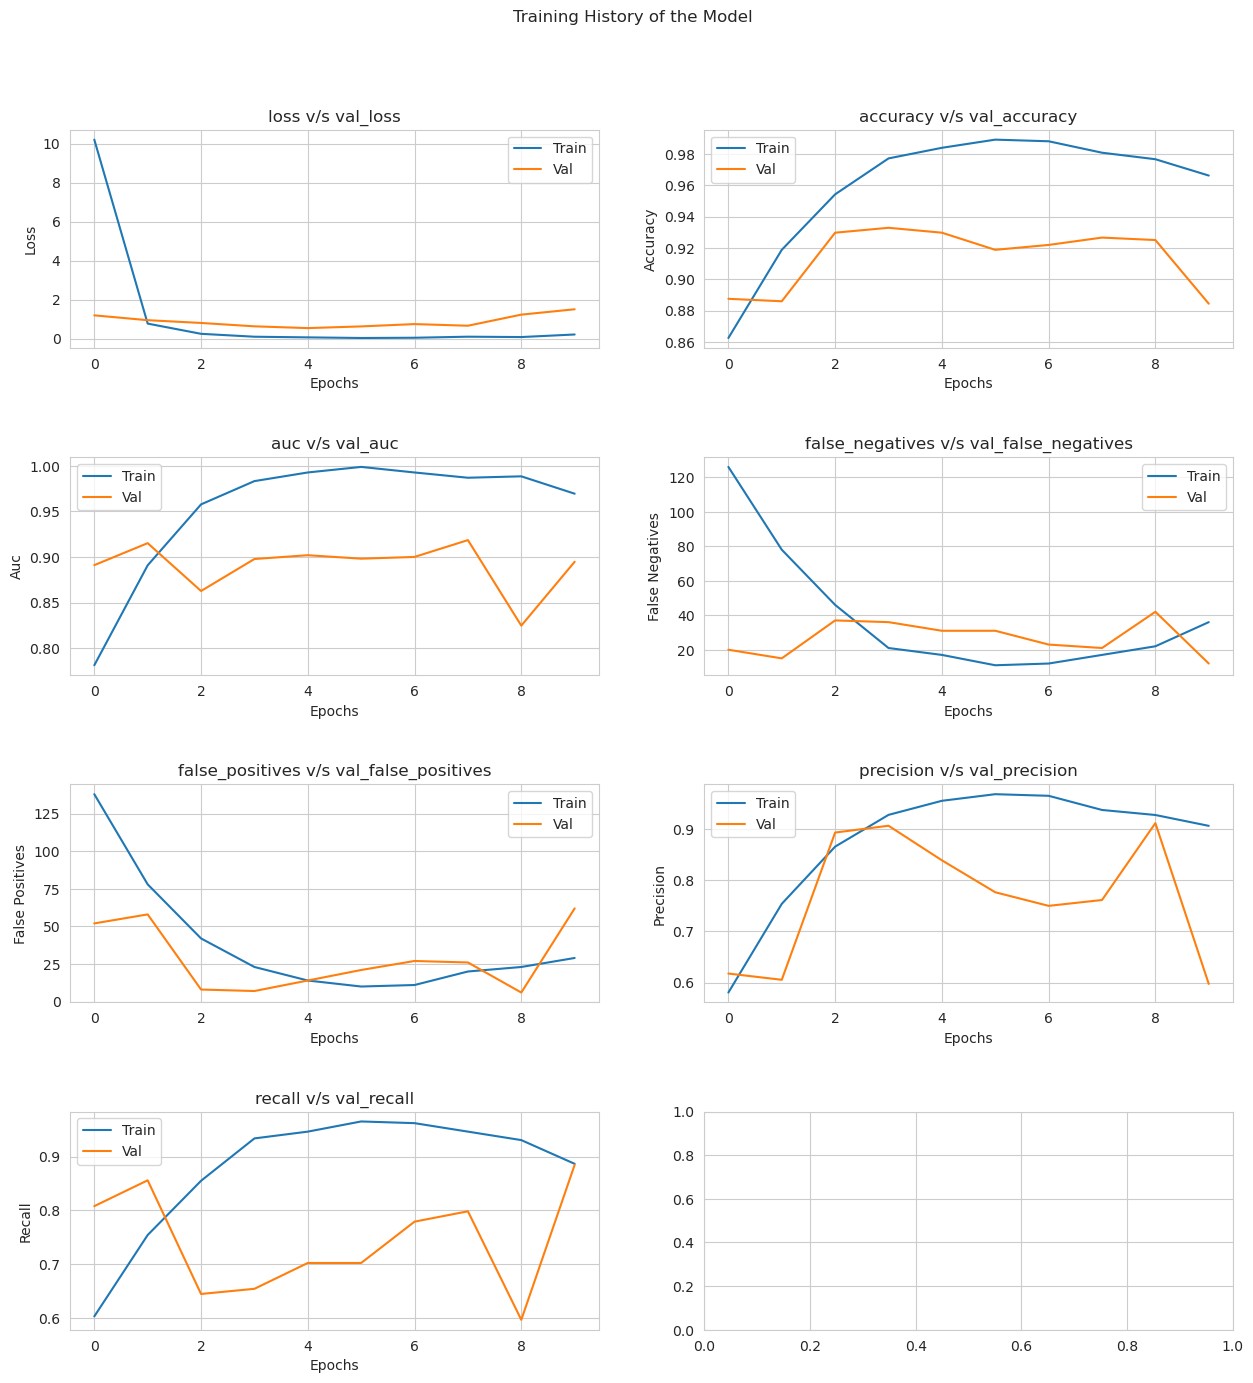

20/20 [==============================] - 72s 4s/step


In [ ]:
me.training_history()
me.predict()

              precision    recall  f1-score   support



Not Infected       0.95      0.97      0.96       538

    Infected       0.82      0.71      0.76       102



    accuracy                           0.93       640

   macro avg       0.88      0.84      0.86       640

weighted avg       0.93      0.93      0.93       640




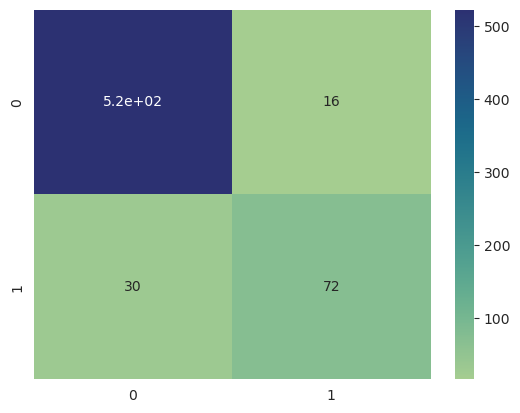

In [ ]:
me.class_report()

### Saving essential data

In [ ]:
mh["ResNet152"] = {"Predictions": tuner.predictions_raw.tolist(),
                   "Threshold": float(tuner.threshold),
                   "Ground Truth" : tuner.test.labels,
                   "History" : history.history
                   }

## VGG16

In [ ]:
model, history, test = experiment_model(cnns.vgg16, 
                                        cnns.VGG16(include_top=False, 
                                                            input_shape=(200,200,3)),
                                        (200,200), "MH")


58889256/58889256 [==============================] - 0s 0us/step

Found 1920 validated image filenames belonging to 2 classes.

Found 640 validated image filenames belonging to 2 classes.

Found 640 validated image filenames belonging to 2 classes.

Epoch 1/25

60/60 [==============================] - 298s 5s/step - loss: 7.4638 - accuracy: 0.8568 - auc: 0.7549 - false_negatives: 140.0000 - false_positives: 135.0000 - precision: 0.5673 - recall: 0.5584 - val_loss: 0.9392 - val_accuracy: 0.9187 - val_auc: 0.8503 - val_false_negatives: 37.0000 - val_false_positives: 15.0000 - val_precision: 0.8171 - val_recall: 0.6442

Epoch 2/25

60/60 [==============================] - 294s 5s/step - loss: 1.1612 - accuracy: 0.8984 - auc: 0.8567 - false_negatives: 89.0000 - false_positives: 106.0000 - precision: 0.6826 - recall: 0.7192 - val_loss: 1.1168 - val_accuracy: 0.9172 - val_auc: 0.8067 - val_false_negatives: 49.0000 - val_false_positives: 4.0000 - val_precision: 0.9322 - val_recall: 0.5288

E

### Threshold Tuning

In [ ]:
tuner = ThresholdTuner(model, test)

20/20 [==============================] - 70s 4s/step

Best Threshold=0.338527, F-score=0.767 using PR Curve


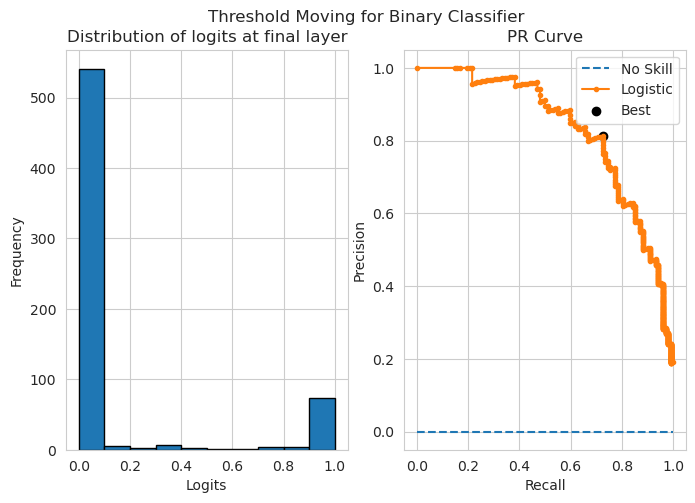

In [ ]:
tuner.find_optimal_thresholds()

### Model Evaluation

In [ ]:
me = ModelEvaluator(history, ["Not Infected", "Infected"], model, test, tuner.threshold)

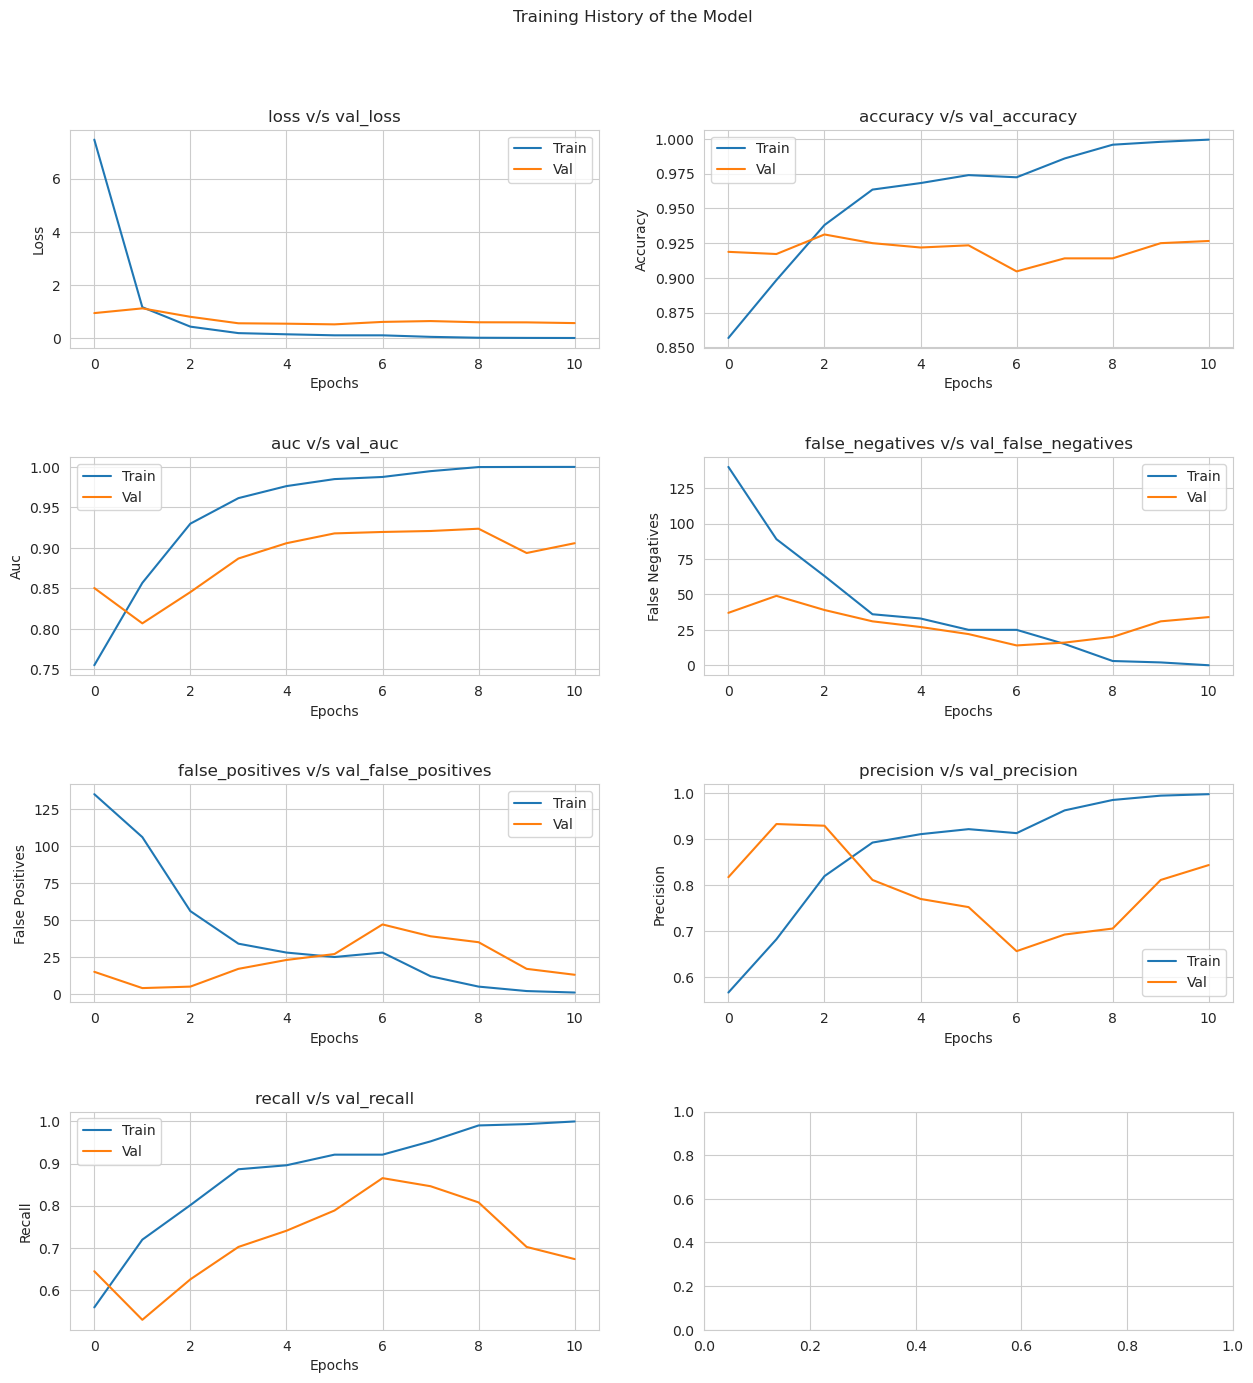

20/20 [==============================] - 70s 4s/step


In [ ]:
me.training_history()
me.predict()

              precision    recall  f1-score   support



Not Infected       0.95      0.97      0.96       538

    Infected       0.81      0.73      0.77       102



    accuracy                           0.93       640

   macro avg       0.88      0.85      0.86       640

weighted avg       0.93      0.93      0.93       640




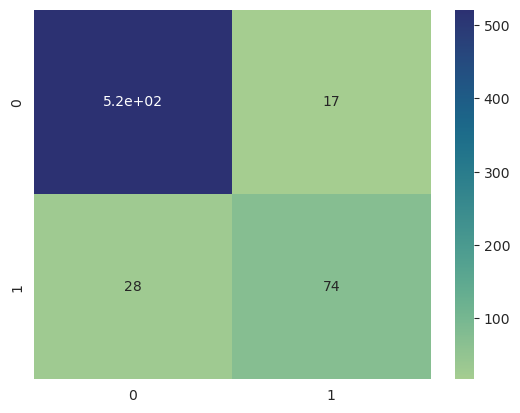

In [ ]:
me.class_report()

### Saving essential data

In [ ]:
mh["VGG16"] = {"Predictions": tuner.predictions_raw.tolist(),
               "Threshold": float(tuner.threshold),
               "Ground Truth" : tuner.test.labels,
               "History" : history.history
               }

## DenseNet169

In [ ]:
model, history, test = experiment_model(cnns.densenet, 
                                        cnns.DenseNet169(include_top=False, 
                                                         input_shape=(200,200,3)),
                                        (200,200), "MH")


51877672/51877672 [==============================] - 0s 0us/step

Found 1920 validated image filenames belonging to 2 classes.

Found 640 validated image filenames belonging to 2 classes.

Found 640 validated image filenames belonging to 2 classes.

Epoch 1/25

60/60 [==============================] - 313s 5s/step - loss: 3.5988 - accuracy: 0.8745 - auc: 0.8013 - false_negatives: 121.0000 - false_positives: 120.0000 - precision: 0.6203 - recall: 0.6183 - val_loss: 1.1617 - val_accuracy: 0.9234 - val_auc: 0.8262 - val_false_negatives: 47.0000 - val_false_positives: 2.0000 - val_precision: 0.9661 - val_recall: 0.5481

Epoch 2/25

60/60 [==============================] - 294s 5s/step - loss: 0.7038 - accuracy: 0.9198 - auc: 0.8865 - false_negatives: 78.0000 - false_positives: 76.0000 - precision: 0.7587 - recall: 0.7539 - val_loss: 0.5418 - val_accuracy: 0.9344 - val_auc: 0.9190 - val_false_negatives: 27.0000 - val_false_positives: 15.0000 - val_precision: 0.8370 - val_recall: 0.7404

Ep

### Threshold Tuning

In [ ]:
tuner = ThresholdTuner(model, test)

20/20 [==============================] - 73s 4s/step

Best Threshold=0.001790, F-score=0.766 using PR Curve


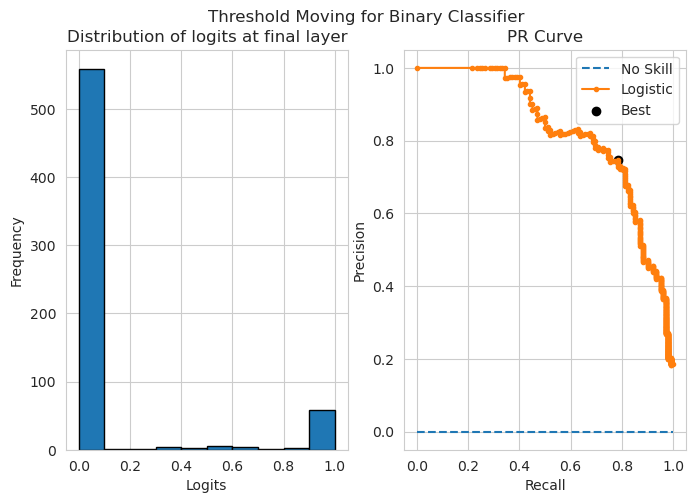

In [ ]:
tuner.find_optimal_thresholds()

### Model Evaluation

In [ ]:
me = ModelEvaluator(history, ["Not Infected", "Infected"], model, test, tuner.threshold)

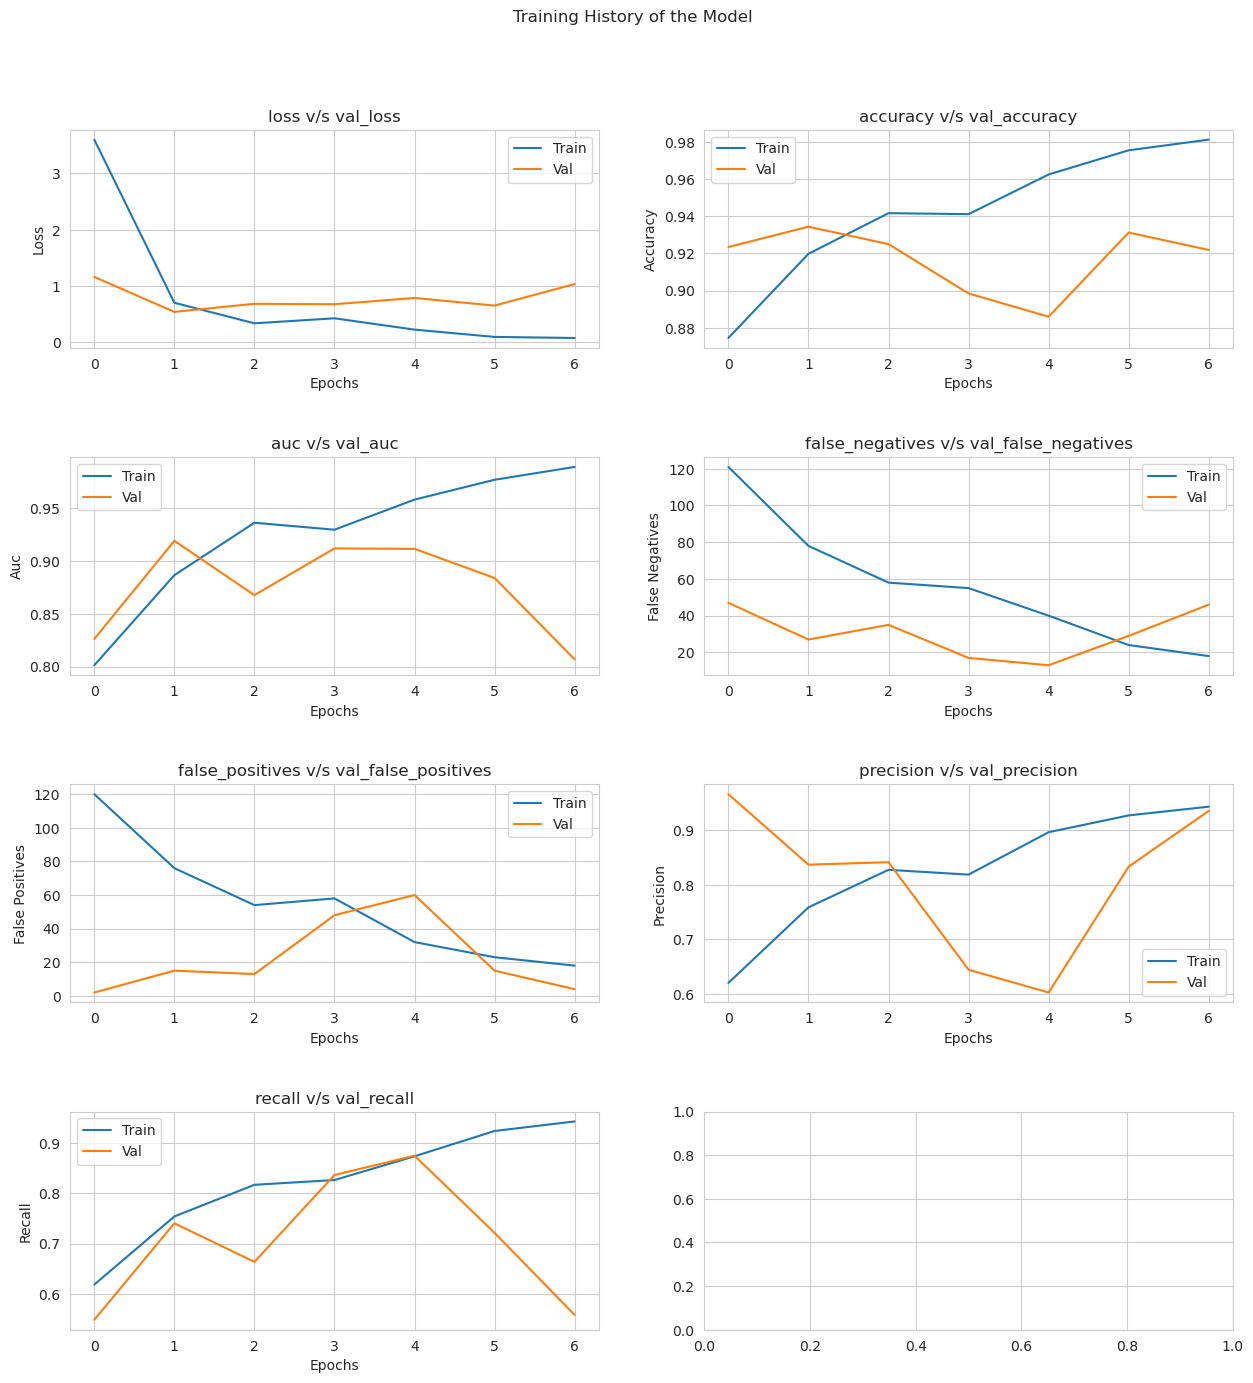

20/20 [==============================] - 70s 4s/step


In [ ]:
me.training_history()
me.predict()

              precision    recall  f1-score   support



Not Infected       0.96      0.95      0.95       538

    Infected       0.75      0.78      0.77       102



    accuracy                           0.92       640

   macro avg       0.85      0.87      0.86       640

weighted avg       0.93      0.92      0.92       640




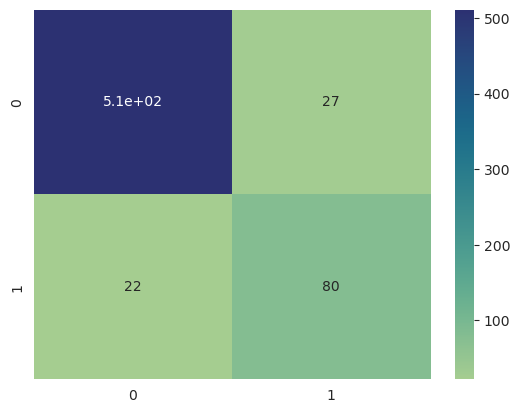

In [ ]:
me.class_report()

### Saving essential data

In [ ]:
mh["DenseNet169"] = {"Predictions": tuner.predictions_raw.tolist(),
                     "Threshold": float(tuner.threshold),
                     "Ground Truth" : tuner.test.labels,
                     "History" : history.history
                     }

## Serialization of all the model data to a JSON file

In [ ]:
with open("/kaggle/working/MH.json", 'w') as fp:
    json.dump(mh, fp)

## Model Comparison

In [31]:
# A class for model performance comparison for the particular dataset.
class ModelComparison:

    # Initialization of the class using the required parameters.
    def __init__(self, json_file_path : str, dataset : str):
        self.history = json.load(open(json_file_path, "r"))
        self.dataset = dataset
        self.colors = ["red", "orange", "yellow", "green"]
        self.models = ['EfficientNetB0', 'ResNet152', 'VGG16', 'DenseNet169']
    
    # Plotting a particular metric for all models.
    def __plot_metric(self, ax, metric: str):
        
        for model_idx in range(0, len(self.models)):
            ax.plot(self.history[self.models[model_idx]]["History"][metric], 
                    color=self.colors[model_idx])
                    
        ax.title.set_text(metric + " Comparison")
        ax.set_xlabel('Epochs')
        ax.set_ylabel(metric.title())
        ax.legend(self.models)
    
    # Plotting the comparative analysis of models based on
    # training history.
    def training_history(self):
        rows = 3
        columns = 2
        c = 0
        metrics = ["val_loss", "val_accuracy", "val_auc", "val_false_positives", "val_precision", "val_recall"]
        fig, axs = plt.subplots(rows, columns, 
                                figsize=(15,15))

        for metric in metrics:
            self.__plot_metric(axs[c//columns, c%columns], 
                               metric)
            c += 1

        fig.suptitle("Comparison of Model Performance on "+self.dataset)
        plt.subplots_adjust(bottom=0.1, 
                            top=0.9, hspace=0.5)
        plt.show()
    
    def comparative_roc_curve(self):
        plt.figure(figsize=(3,3))
        plt.plot([0,1], [0,1], linestyle='--', label='No Skill', color="black")
        for model, color in zip(self.models, self.colors):
            ground_truth = self.history[model]["Ground Truth"]
            predictions = self.history[model]["Predictions"]
            fpr, tpr, thresholds = roc_curve(ground_truth, predictions)
            plt.plot(fpr, tpr, marker='.', label=model.replace("_",""), color=color)  
        plt.title("Comparative ROC Curve for Binary Classifier")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()

### Diabetic Retinopathy

In [32]:
mc = ModelComparison("/kaggle/input/modelinfo/DR.json", "DR")

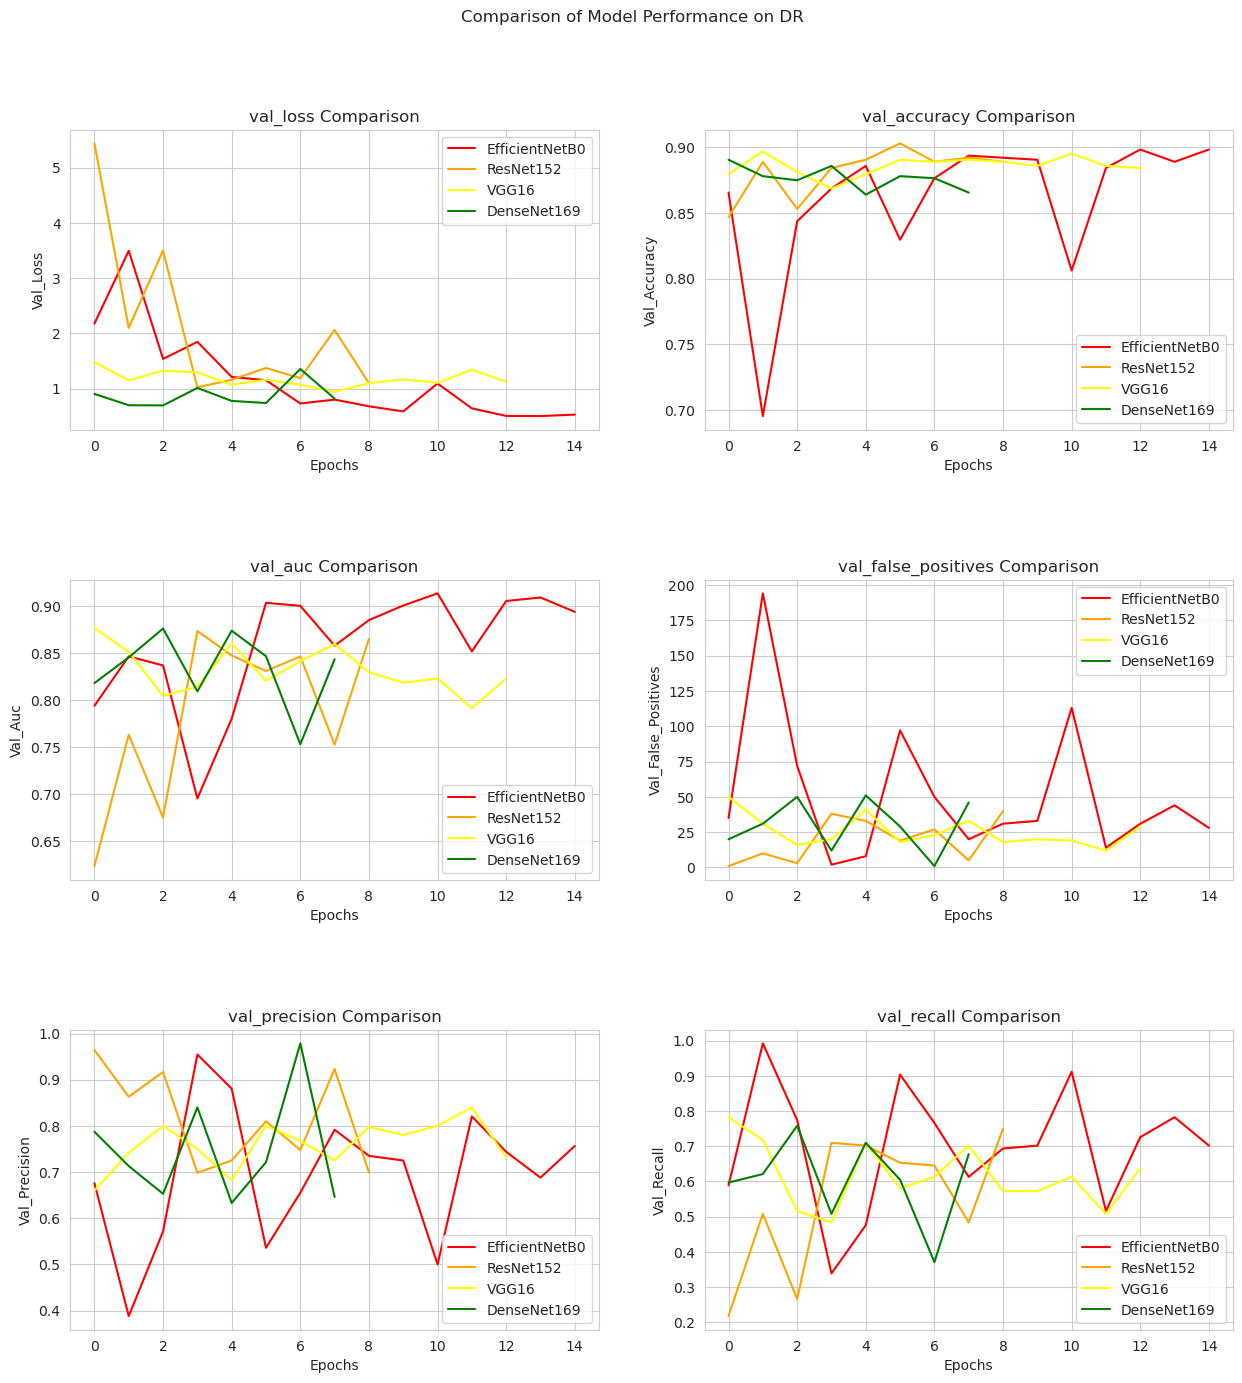

In [33]:
mc.training_history()

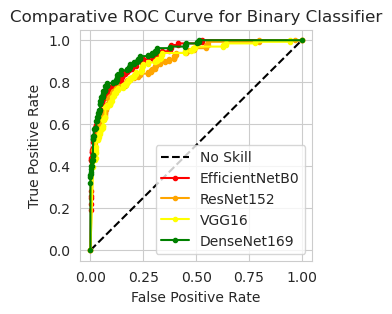

In [34]:
mc.comparative_roc_curve()

### Macular Hole

In [35]:
mc = ModelComparison("/kaggle/input/modelinfo/MH.json", "MH")

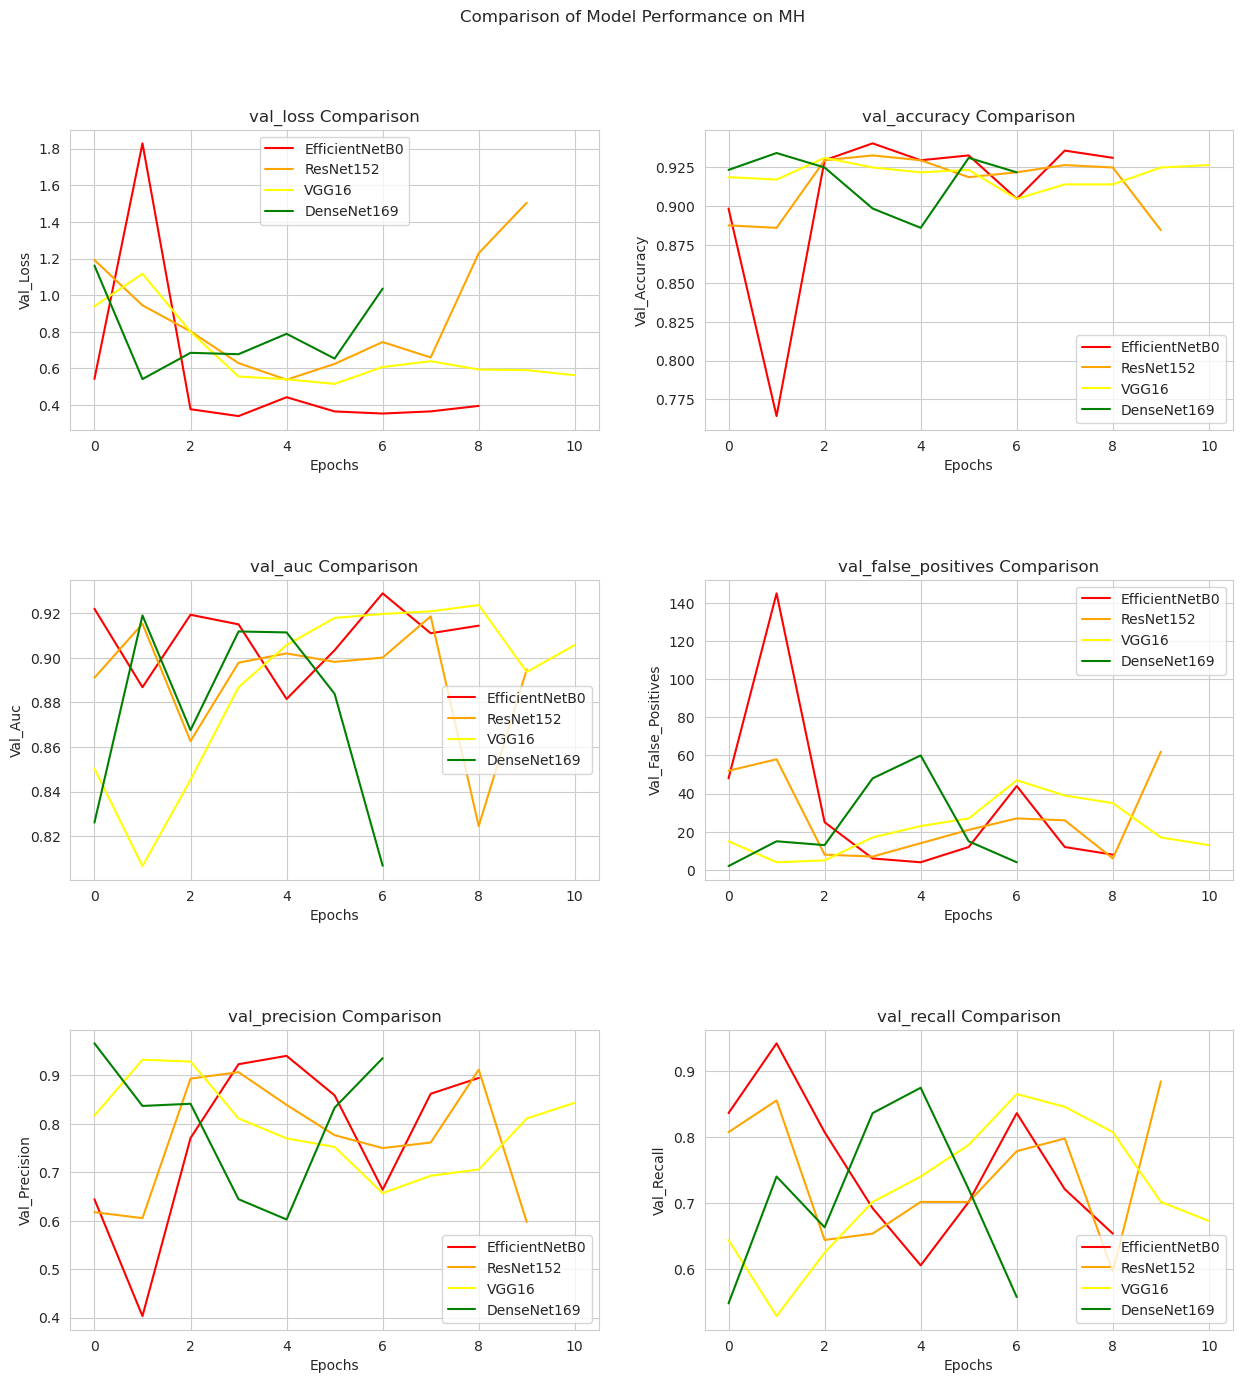

In [36]:
mc.training_history()

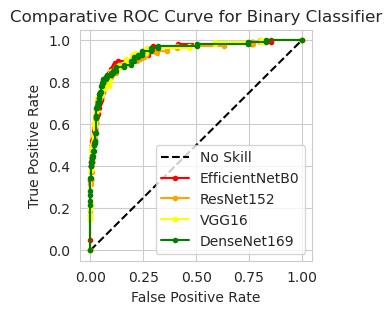

In [37]:
mc.comparative_roc_curve()

## Ensemble Models

In [ ]:
class Ensembles:
    
    def __init__(self, json_file : str, disease : str, models_in_ensemble : list):
        self.model = json.load(open(json_file, "r"))
        self.disease = disease
        self.models_in_ensemble = models_in_ensemble
        self.thresholds = np.array([])
        self.raw_predictions = None
        self.predictions_dimensions = np.array(self.model["VGG16"]["Predictions"]).shape
        self.__extract_thresholds()
        self.final_predictions = None
        #self.final_raw_predictions = None
    
    def __extract_thresholds(self):
        for m in self.models_in_ensemble:
            self.thresholds = np.append(self.thresholds, self.model[m]["Threshold"])
    
    def __clip_logits(self, a, toe : str):
        if toe == "mean":
           precision, recall, thresholds = precision_recall_curve(self.test.labels, self.predictions_raw)
           fscore = (2 * precision * recall) / (precision + recall)
           ix = np.argmax(fscore)
           print('Best Threshold=%f, F-score=%.3f using PR Curve' % (thresholds[ix], fscore[ix]))
           return int(a >= threshold[ix])
        return list(map(int, a >= self.thresholds))
    
    def mean_ensemble(self, evaluate : bool):
        overall_predictions_raw = np.zeros(self.predictions_dimensions)
        for weak_learner in self.models_in_ensemble:
            overall_predictions_raw += self.model[weak_learner]["Predictions"]
        overall_predictions_raw /= len(self.models_in_ensemble)
        precision, recall, thresholds = precision_recall_curve(self.model["VGG16"]["Ground Truth"], 
                                                               overall_predictions_raw)
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.argmax(fscore)
        print('Best Threshold=%f' % (thresholds[ix]))
        overall_predictions = list(map(lambda k : k >= thresholds[ix], overall_predictions_raw))
        self.final_predictions = overall_predictions
        if evaluate:
           self.evaluate_ensemble(self.model["VGG16"]["Ground Truth"], overall_predictions)
        
    def mode_ensemble(self, evaluate : bool):
        overall_predictions = []
        for weak_learner in self.models_in_ensemble:
            model_predictions = list(map(lambda k : k >= self.model[weak_learner]["Threshold"], 
                                    self.model[weak_learner]["Predictions"]))
            overall_predictions.append(model_predictions)
        overall_predictions = np.array(overall_predictions)
        print(overall_predictions.shape)
        overall_predictions = st.mode(overall_predictions).mode.flatten()
        print(overall_predictions.shape)
        self.final_predictions = overall_predictions
        if evaluate:
           self.evaluate_ensemble(self.model["VGG16"]["Ground Truth"], overall_predictions)
        
    def weighted_avg_ensemble(self, evaluate : bool):
        overall_predictions_raw = np.zeros(self.predictions_dimensions)
        f1_scores = []
        for weak_learner in self.models_in_ensemble:
            model_predictions = list(map(lambda k : k >= self.model[weak_learner]["Threshold"], 
                                    self.model[weak_learner]["Predictions"]))
            f1 = f1_score(self.model[weak_learner]["Ground Truth"], model_predictions)
            f1_scores.append(f1)
            overall_predictions_raw += np.array(self.model[weak_learner]["Predictions"])*f1
        overall_predictions_raw /= sum(f1_scores)
        precision, recall, thresholds = precision_recall_curve(self.model["VGG16"]["Ground Truth"], 
                                                               overall_predictions_raw)
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.argmax(fscore)
        print('Best Threshold=%f'% (thresholds[ix]))
        overall_predictions = list(map(lambda k : k >= thresholds[ix], overall_predictions_raw))
        self.final_predictions = overall_predictions
        if evaluate:
           self.evaluate_ensemble(self.model["VGG16"]["Ground Truth"], overall_predictions)
        
    def evaluate_ensemble(self, ground_truth, predictions):
        sns.heatmap(tf.math.confusion_matrix(ground_truth, predictions, num_classes=2), 
                    annot=True, cmap="crest")
        print(classification_report(ground_truth, predictions, target_names=["Not Infected", "Infected"]))

### Diabetic Retinopathy

In [ ]:
e = Ensembles("/kaggle/input/modelinfo/DR.json", "DR",
              ["EfficientNetB0", "DenseNet169", "VGG16"])

### Mean Ensemble

Best Threshold=0.663604
              precision    recall  f1-score   support

Not Infected       0.93      0.95      0.94       508
    Infected       0.81      0.74      0.77       132

    accuracy                           0.91       640
   macro avg       0.87      0.85      0.86       640
weighted avg       0.91      0.91      0.91       640



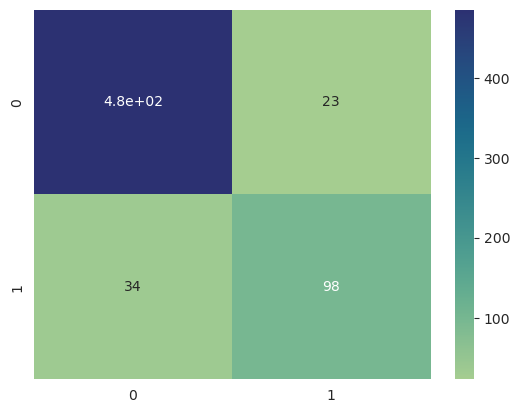

In [ ]:
e.mean_ensemble(True)

#### Weighted Average Ensemble

Best Threshold=0.657362
              precision    recall  f1-score   support

Not Infected       0.94      0.95      0.95       508
    Infected       0.81      0.75      0.78       132

    accuracy                           0.91       640
   macro avg       0.87      0.85      0.86       640
weighted avg       0.91      0.91      0.91       640



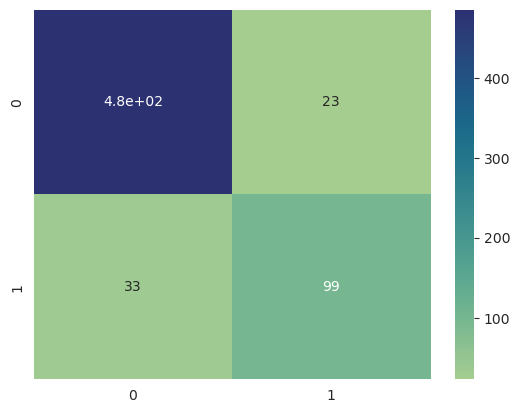

In [ ]:
e.weighted_avg_ensemble(True)

#### Mode Ensemble

(3, 640)
(640,)
              precision    recall  f1-score   support

Not Infected       0.94      0.96      0.95       508
    Infected       0.82      0.75      0.78       132

    accuracy                           0.91       640
   macro avg       0.88      0.85      0.86       640
weighted avg       0.91      0.91      0.91       640



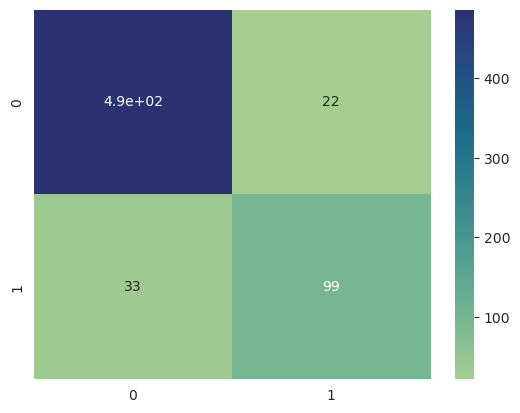

In [ ]:
e.mode_ensemble(True)

### Macular Hole

In [ ]:
e = Ensembles("/kaggle/input/modelinfo/MH.json", "MH",
              ["EfficientNetB0", "DenseNet169", "VGG16"])

#### Mean Ensemble

Best Threshold=0.663604
              precision    recall  f1-score   support

Not Infected       0.93      0.95      0.94       508
    Infected       0.81      0.74      0.77       132

    accuracy                           0.91       640
   macro avg       0.87      0.85      0.86       640
weighted avg       0.91      0.91      0.91       640



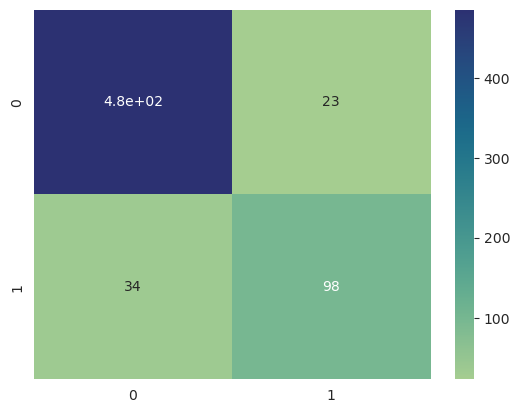

In [ ]:
e.mean_ensemble(True)

#### Mode Ensemble

(3, 640)
(640,)
              precision    recall  f1-score   support

Not Infected       0.94      0.96      0.95       508
    Infected       0.82      0.75      0.78       132

    accuracy                           0.91       640
   macro avg       0.88      0.85      0.86       640
weighted avg       0.91      0.91      0.91       640



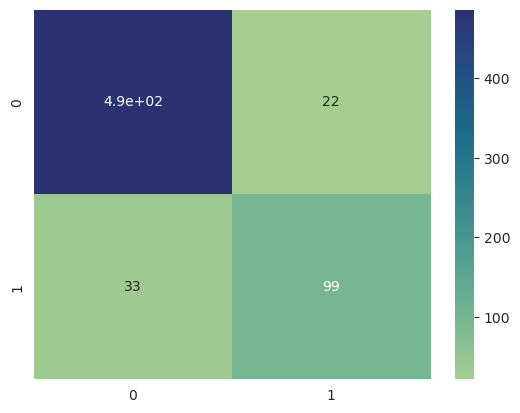

In [ ]:
e.mode_ensemble(True)

#### Weighted Average Ensemble

Best Threshold=0.657362
              precision    recall  f1-score   support

Not Infected       0.94      0.95      0.95       508
    Infected       0.81      0.75      0.78       132

    accuracy                           0.91       640
   macro avg       0.87      0.85      0.86       640
weighted avg       0.91      0.91      0.91       640



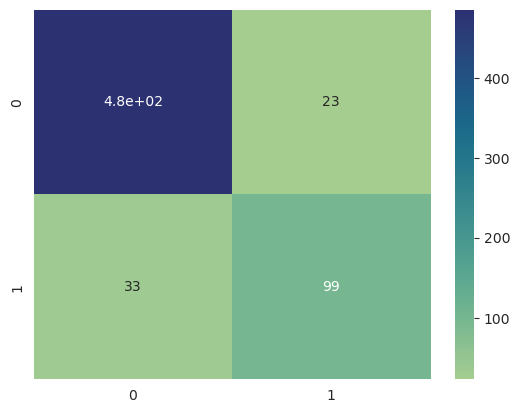

In [ ]:
e.weighted_avg_ensemble(True)

# Multilabel Classification

In [ ]:
class MultilabelClassifier:
    
    def __init__(self, json_dr : str, json_mh : str, dr_fx : str):
        self.dr = json.load(open(json_dr, "r"))
        self.mh = json.load(open(json_mh, "r"))
        self.dr_fx = dr_fx
        self.dr_pred = None
        self.dr_raw = None
        self.mh_fx = "mode"
        self.mh_pred = None
        self.mh_raw = None
        self.models = ["EfficientNetB0", "DenseNet169", "VGG16"]
        self.pred_raw = None
        self.pred = None
    
    def classifier(self):
        e = Ensembles("/kaggle/input/modelinfo/DR.json", "DR",
                      ["EfficientNetB0", "DenseNet169", "VGG16"])
        if self.dr_fx == "mean":
            e.mean_ensemble(False)
            #self.dr_
            self.dr_pred = e.final_predictions
        elif self.dr_fx == "mode":
            e.mode_ensemble(False)
            self.dr_pred = e.final_predictions
        elif self.dr_fx == "wmean":
            e.weighted_avg_ensemble(False)
            self.dr_pred = e.final_predictions
        m = Ensembles("/kaggle/input/modelinfo/MH.json", "MH",
                      ["EfficientNetB0", "DenseNet169", "VGG16"])
        m.mode_ensemble(False)
        self.mh_pred = m.final_predictions
        #print(self.dr_pred)
        self.pred = list(zip(self.dr_pred, self.mh_pred))
        self.ground_truth = list(zip(self.dr["VGG16"]["Ground Truth"], 
                                     self.mh["VGG16"]["Ground Truth"]))
    
    def evaluate_classifier(self):
        print(classification_report(self.ground_truth, self.pred, 
                                    target_names=["DR", "MH"]))
        print(roc_auc_score(self.ground_truth, self.pred))

## Mean-Mode

In [ ]:
multilabel = MultilabelClassifier("/kaggle/input/modelinfo/DR.json", 
                                  "/kaggle/input/modelinfo/MH.json",
                                  "mean")

In [ ]:
multilabel.classifier()
multilabel.evaluate_classifier()

Best Threshold=0.663604
(3, 640)
(640,)
              precision    recall  f1-score   support

          DR       0.81      0.74      0.77       132
          MH       0.78      0.78      0.78       102

   micro avg       0.80      0.76      0.78       234
   macro avg       0.80      0.76      0.78       234
weighted avg       0.80      0.76      0.78       234
 samples avg       0.27      0.27      0.27       234

0.8601425460136768


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Mode-Mode

In [ ]:
multilabel = MultilabelClassifier("/kaggle/input/modelinfo/DR.json", 
                                  "/kaggle/input/modelinfo/MH.json",
                                  "mode")

In [ ]:
multilabel.classifier()
multilabel.evaluate_classifier()

(3, 640)
(640,)
(3, 640)
(640,)
              precision    recall  f1-score   support

          DR       0.82      0.75      0.78       132
          MH       0.78      0.78      0.78       102

   micro avg       0.80      0.76      0.78       234
   macro avg       0.80      0.77      0.78       234
weighted avg       0.80      0.76      0.78       234
 samples avg       0.27      0.27      0.27       234

0.8625286113918681


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## WMean-Mode

In [ ]:
multilabel = MultilabelClassifier("/kaggle/input/modelinfo/DR.json", 
                                  "/kaggle/input/modelinfo/MH.json",
                                  "wmean")

In [ ]:
multilabel.classifier()
multilabel.evaluate_classifier()

Best Threshold=0.657362
(3, 640)
(640,)
              precision    recall  f1-score   support

          DR       0.81      0.75      0.78       132
          MH       0.78      0.78      0.78       102

   micro avg       0.80      0.76      0.78       234
   macro avg       0.80      0.77      0.78       234
weighted avg       0.80      0.76      0.78       234
 samples avg       0.27      0.27      0.27       234

0.8620364854076161


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
